In [1]:
!pip install openbox
!pip install shapely
!pip install plotly
!pip install torch

In [2]:
class Data:
    def __init__(self, sensorPositions, space, epsilon):
        self.radius = 1
        self.placeHolders = sensorPositions
        self.epsilon = epsilon
        self.space = space
        # self.SensorPlaceHolderSetup()
        
    def frange(self, start, stop, step):
        steps = []
        while start <= stop:
            steps.append(start)
            start +=step
            
        return steps

    # def SensorPlaceHolderSetup(self):
    #     Xs = self.frange(0, self.space[0], self.epsilon)
    #     Ys = self.frange(0, self.space[1], self.epsilon)
            
    #     for x in Xs:
    #       for y in Ys:
    #         self.placeHolders.append([x, y])

    def GetSensorConfiguration(self):
        from collections import Counter
        sensorLocations, sensorTypes = self.GetSensorLocations()
        
        _, rooms = pf.ParseWorld(simworldname = '')
        
        summaryDict = Counter(sensorTypes)

        # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
        configurationSummary = []
        for key in summaryDict:
            if (key == 1):
                configurationSummary.append(['motion sensors', summaryDict[key]])

            elif (key == 2):
                configurationSummary.append(['beacon sensors', summaryDict[key]])

        configurationDetails = []
        for index, loc in enumerate(sensorLocations):
            room = ""
            for r in rooms:
                if loc[0] >= rooms[r][0][0] and loc[0] <= rooms[r][1][0] and loc[1] >= rooms[r][0][1] and loc[1] <= rooms[r][1][1]:
                    room = r
                    break

            if (sensorTypes[index] == 1):
                configurationDetails.append(tuple([loc, room, 'motion sensors']))

            elif (sensorTypes[index] == 2):
                configurationDetails.append(tuple([loc, room, 'beacon sensors']))

        return [[configurationSummary, [tuple(configurationDetails)]], self.radius]


    def GetSensorLocations(self):
        sensorLocations = []
        sensorTypes = []
        for index, sensorIndicator in enumerate(self.placeHolders):
            sensorLocations.append(self.placeHolders[index])

            # TODO: DIFFERENT SENSOR TYPE DEFINITIONS SHOULD BE ADDED HERE:
            sensorTypes.append(1)


        return sensorLocations, sensorTypes


class BOVariables:
    def __init__(self, Data_path, epsilon, initSensorNum, maxSensorNum, radius, sampleSize):
        self.epsilon = epsilon
        self.Data_path = Data_path
        self.initSensorNum = initSensorNum
        self.maxSensorNum = maxSensorNum
        self.radius = radius
        self.sensor_distribution, self.types, self.space, self.rooms, self.agentTraces = self.ModelsInitializations()

    def ModelsInitializations(self):
        #----- Space and agent models -----: 
        # simworldname = self.Data_path + '/Configuration Files/simulationWorld2.xml'
        simworldname = ''
        agentTraces = []
        directory = os.fsencode(self.Data_path + 'Agent Trace Files/')
            
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.endswith(".csv"): 
                agentTraces.append(self.Data_path + 'Agent Trace Files/' + filename)

        # Parsing the space model: 
        space, rooms = pf.ParseWorld(simworldname)

        xs = []
        for i in space:
          for j in i:
            xs.append(j)
        A = list(set(xs))
        A.sort()
        space = [A[-1], A[-2]]

        # User parameters 
        types, sensor_distribution = pf.GetUsersParameters()

        roomsList = []
        for room in sensor_distribution:
            roomsList.append(room)
              
        return sensor_distribution, types, space, rooms, agentTraces


def frange(start, stop, step):
    steps = []
    while start <= stop:
        steps.append(start)
        start +=step
        
    return steps

def MakeSensorCombinations(start, end, epsilon, sensorType, room):
    a1, b1 = makeBoundaries(epsilon, start[0], end[0])
    a2, b2 = makeBoundaries(epsilon, start[1], end[1])    
    Xs = frange(a1, b1, epsilon)
    Ys = frange(a2, b2, epsilon)
    
    points = list(itertools.product(list(itertools.product(Xs, Ys)), [room], [sensorType[0]])) 
    C = itertools.combinations(points, distribution[room][types.index(sensorType)])

    return C

def PreProcessor(df):
    # df['motion sensors'] = df['motion sensors'].apply(ast.literal_eval)
    df['motion sensors'] = df['motion sensors'].apply(lambda s: list(map(int, s)))
    #df['motion sensors'] = df['motion sensors'].apply(lambda s: s + [1])
    # df['beacon sensors'] = df['beacon sensors'].apply(ast.literal_eval)
    try:
      df['beacon sensors'] = df['beacon sensors'].apply(lambda s: list(map(int, s)))
    except:
      pass

    pre_activity = ''
    save_index = 0

    for index, row in df.iterrows():
        save_index = index
        Activity = row['activity']

        if Activity != pre_activity:
            if pre_activity != '':
                df.at[index - 1, 'motion sensors'] += [0]
            else:
                df.at[index, 'motion sensors'] += [1]

            pre_activity = Activity
        else:
            df.at[index - 1, 'motion sensors'] += [1]

    df.at[save_index, 'motion sensors'] += [0]

    sensors = set([])

    previous_M = None
    previous_B = None
    output_file = []

    for index, row in df.iterrows():
      T = row['time']
      M = row['motion sensors']
      try:
        B = row['beacon sensors']
      except:
        pass

      Activity = row['activity']
      Activity = Activity.replace(' ', '_')
      MotionSensor_Names = []
      sensorNames = []
      MotionSensor_Message = []
      BeaconSensor_Names = []
      BeaconSensor_Message = []
      

      # time = convertTime(T)
      time = "2020-06-16 " + T + ".00"

      # Motion Sensor
      for i in range(len(M)):
        sensorNames.append(Name(i, 'M'))
        if M[i] == 1:
          if (previous_M != None):
            if (previous_M[i] == 0):
              MotionSensor_Names.append(Name(i,'M'))
              MotionSensor_Message.append('ON')

          else:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('ON')

        if previous_M != None:
          if M[i] == 0 and previous_M[i] == 1:
            MotionSensor_Names.append(Name(i,'M'))
            MotionSensor_Message.append('OFF')

      previous_M = M
      # Beacon Sensor

      try:
        for i in range(len(B)):
          sensorNames.append(Name(i, 'B'))
          if B[i] == 1:
            BeaconSensor_Names.append(Name(i,'B'))
            BeaconSensor_Message.append('ON')
          if previous_B != None:
            if B[i] == 0 and previous_B[i] == 1: 
              BeaconSensor_Names.append(Name(i,'B'))
              BeaconSensor_Message.append('OFF')
        previous_B = B

      except:
        pass

      for m in range(len(MotionSensor_Names)):
        output_file.append(time +' '+ MotionSensor_Names[m] + ' ' + MotionSensor_Names[m] + ' ' + MotionSensor_Message[m] + ' ' + Activity)
        
      for s in sensorNames:
          sensors.add(s)

    return output_file, list(sensors)

#returns the name of the sensor
def Name(number, typeSensor):
    if number < 10:
      return typeSensor + str(0) + str(number)
    else:
      return typeSensor + str(number)

#converts epoch time to human readable
def convertTime(posix_timestamp):
    tz = pytz.timezone('MST')
    dt = datetime.fromtimestamp(posix_timestamp, tz)
    time = dt.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
    return time

def MakeDataBoundaries(height = 10.5, width = 6.6, MaxSensors = 15):
    from collections import defaultdict, OrderedDict

    d = dict()

    for idx in range(MaxSensors):
            d['x' + str(idx)] = (0.5, width - 0.5)
            d['y' + str(idx)] = (0.5, height - 0.5)

    return d

def black_box_function(sample, simulateMotionSensors = True, simulateEstimotes = False, Plotting = False):       
    files = []

    import sys
    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/')
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/'

    else:
        # sys.path.append('../../Codes/SensorDeploymentOptimization/')
        sys.path.append('..')
        Data_path = '../../Codes/SensorDeploymentOptimization/'

    all_sensors = set([])

    for agentTrace in BOV.agentTraces:
        df_ = sim_sis.RunSimulator(BOV.space, 
                                   BOV.rooms, 
                                   agentTrace,
                                   sample.GetSensorConfiguration(), 
                                   simulateMotionSensors, 
                                   simulateEstimotes, 
                                   Plotting, 
                                   BOV.Data_path)
        
        dataFile, sensors = PreProcessor(df_)
        all_sensors.update(sensors)
        files.append(dataFile)
        
    
    if (runningOnGoogleColab == True):
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/CASAS/AL-Smarthome')

    else:
        sys.path.append('../../Codes/CASAS/AL-Smarthome')

    import al
    import imp
    imp.reload(al)
    all_sensors = list(all_sensors)

    f1_score = (al.leave_one_out(files, all_sensors)[0]) * 100

    if f1_score < 0:
        f1_score = 0

    return 100 - f1_score

def function_to_be_optimized(config):
    sensorPositions = []
    sensor_xy = []

    for i in range(1, CONSTANTS['max_sensors'] + 1):
        if (config['x' + str(i)] > 0):
            sensor_xy.append(config['x' + str(i)])
            sensor_xy.append(config['y' + str(i)])
            sensorPositions.append(sensor_xy)
            sensor_xy = []
        
          
    # print(sensorPositions)
    data = Data(sensorPositions, BOV.space, CONSTANTS['epsilon'])
    
    # print(data.GetSensorConfiguration())
    result = dict()

    result['objs'] = np.stack([black_box_function(data), len(sensorPositions)], axis=-1)
    
    return result

In [ ]:
CONSTANTS = {
    'iterations': 100,
    'initial_samples': 10,
    'restarts_number': 10,
    'raw_samples': 10,
    'candidates_num': 1,
    'sequential': True,
    'epsilon': 1,
    'radius': 1,
    'height': 8.0,
    'width': 8.0,
    'max_sensors': 15
}

runningOnGoogleColab = False
    
if __name__ ==  '__main__':
    import sys

    # if (runningOnGoogleColab == True):
    #     from google.colab import drive    
    #     drive.mount('/content/gdrive', force_remount=True)
    #     Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/'
    #     sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/Sensor Simulator/')
        
    # else:
    #     Data_path = '../../Codes/Sensor Simulator/'
    #     sys.path.append('../../Codes/Sensor Simulator/')

    if (runningOnGoogleColab == True):
        from google.colab import drive    
        drive.mount('/content/gdrive', force_remount=True)
        Data_path = 'gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/'
        sys.path.append('gdrive/My Drive/PhD/Thesis/Ideas/Codes/SensorDeploymentOptimization/')

    else:
        Data_path = '../../Codes/SensorDeploymentOptimization/'
        # sys.path.append('../../Codes/SensorDeploymentOptimization/')
        sys.path.append('..')
    
    # from ax import optimize, ChoiceParameter
    from scipy.stats import norm
    from numpy import argmax
    import SIM_SIS_Libraries.SensorsClass
    import SIM_SIS_Libraries.SIM_SIS_Simulator as sim_sis
    import SIM_SIS_Libraries.ParseFunctions as pf
    import itertools
    import numpy as np
    import pandas as pd
    import SIM_SIS_Libraries.PreDeploymentEvaluation as pde
    import copy
    from datetime import datetime
    import pytz
    import ast
    import os
    import random
    import plotly
    import torch

    finalResults = []
    w = CONSTANTS['width'] - 0.5
    h = CONSTANTS['height'] - 0.5

    dataBoundaries = MakeDataBoundaries(
                                        height = CONSTANTS['height'], 
                                        width = CONSTANTS['width'], 
                                        MaxSensors = CONSTANTS['max_sensors']
                                       )

    BOV =  BOVariables(
                       Data_path, 
                       CONSTANTS['epsilon'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['max_sensors'], 
                       CONSTANTS['radius'],
                       CONSTANTS['initial_samples']
                      )

    from openbox import sp
    

    # Define Search Space
    space = sp.Space()

    list_of_variables = []
    for i in range(1, CONSTANTS['max_sensors'] + 1):
        x = sp.Int("x" + str(i), 0, CONSTANTS['width'] - 1, default_value=1)
        y = sp.Int("y" + str(i), 1, CONSTANTS['height'] - 1, default_value=1)
        list_of_variables.append(x)
        list_of_variables.append(y)
    
    space.add_variables(list_of_variables)

    from openbox import Optimizer

    history_list = []
    for index in range(10):
        opt = Optimizer(
            function_to_be_optimized,
            space,
            num_objs=2,
            max_runs=500,
            surrogate_type='prf',
            acq_type = 'ehvi',
            acq_optimizer_type='random_scipy',
            time_limit_per_trial=31000,
            task_id='Shadan',
            init_strategy='sobol',
            ref_point=[100, 15]
        )
        history = opt.run()
        
        import pickle

        with open('.\openbox_results\history' + str(index), 'wb') as handle:
            pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        history_list.append(history)

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[Build Surrogate] Use probabilistic random forest based on scikit-learn. For better performance, please install pyrfr: https://open-box.readthedocs.io/en/latest/installation/install_pyrfr.html
[INFO] [2021-11-20 11:18:24,183] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 1
  x11, Value: 1
  x12, Value: 1
  x13, Value: 1
  x14, Value: 1
  x15, Value: 1
  x2, Value: 1
  x3, Value: 1
  x4, Value: 1
  x5, Value: 1
  x6, Value: 1
  x7, Value: 1
  x8, Value: 1
  x9, Value: 1
  y1, Value: 1
  y10, Value: 1
  y11, Value: 1
  y12, Value: 1
  y13, Value: 1
  y14, Value: 1
  y15, Value: 1
  y2, Value: 1
  y3, Value: 1
  y4, Value: 1
  y5, Value: 1
  y6, Value: 1
  y7, Value: 1
  y8, Value: 1
  y9, Value: 1
, objs=[84.96511005 15.        ].
[INFO] [2021-11-20 11:18:24

  0%|▏                                                                               | 1/500 [00:39<5:28:34, 39.51s/it]

[INFO] [2021-11-20 11:19:20,708] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 4
  x10, Value: 2
  x11, Value: 2
  x12, Value: 4
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 2
  x3, Value: 5
  x4, Value: 1
  x5, Value: 0
  x6, Value: 3
  x7, Value: 1
  x8, Value: 6
  x9, Value: 2
  y1, Value: 2
  y10, Value: 5
  y11, Value: 5
  y12, Value: 7
  y13, Value: 5
  y14, Value: 2
  y15, Value: 5
  y2, Value: 1
  y3, Value: 3
  y4, Value: 2
  y5, Value: 1
  y6, Value: 3
  y7, Value: 5
  y8, Value: 5
  y9, Value: 3
, objs=[58.13452623 14.        ].
[INFO] [2021-11-20 11:19:20,709] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 1
  x11, Value: 1
  x12, Value: 1
  x13, Value: 1
  x14, Value: 1
  x15, Value: 1
  x2, Value: 1
  x3, Value: 1
  x4, Value: 1
  x5, Value: 1
  x6, Value: 1
  x7, Value: 1
  x8, Value: 1
  x9, Value: 1
  y1, Value: 1
  y10, Value: 1
  y11, Value: 1
  y12, Value: 1
  y13, Value: 1
  y14, 

  0%|▎                                                                               | 2/500 [01:36<6:51:00, 49.52s/it]

[INFO] [2021-11-20 11:20:12,634] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 3
  x10, Value: 4
  x11, Value: 7
  x12, Value: 3
  x13, Value: 3
  x14, Value: 1
  x15, Value: 2
  x2, Value: 7
  x3, Value: 0
  x4, Value: 4
  x5, Value: 5
  x6, Value: 7
  x7, Value: 5
  x8, Value: 3
  x9, Value: 7
  y1, Value: 4
  y10, Value: 3
  y11, Value: 1
  y12, Value: 2
  y13, Value: 3
  y14, Value: 5
  y15, Value: 3
  y2, Value: 5
  y3, Value: 7
  y4, Value: 4
  y5, Value: 5
  y6, Value: 6
  y7, Value: 2
  y8, Value: 3
  y9, Value: 7
, objs=[53.25733655 14.        ].
[INFO] [2021-11-20 11:20:12,635] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 4
  x10, Value: 2
  x11, Value: 2
  x12, Value: 4
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 2
  x3, Value: 5
  x4, Value: 1
  x5, Value: 0
  x6, Value: 3
  x7, Value: 1
  x8, Value: 6
  x9, Value: 2
  y1, Value: 2
  y10, Value: 5
  y11, Value: 5
  y12, Value: 7
  y13, Value: 5
  y14, 

  1%|▍                                                                               | 3/500 [02:27<6:59:17, 50.62s/it]

[INFO] [2021-11-20 11:21:02,997] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 1
  x11, Value: 5
  x12, Value: 6
  x13, Value: 2
  x14, Value: 1
  x15, Value: 2
  x2, Value: 2
  x3, Value: 1
  x4, Value: 3
  x5, Value: 0
  x6, Value: 6
  x7, Value: 0
  x8, Value: 3
  x9, Value: 7
  y1, Value: 2
  y10, Value: 1
  y11, Value: 7
  y12, Value: 6
  y13, Value: 4
  y14, Value: 7
  y15, Value: 3
  y2, Value: 1
  y3, Value: 2
  y4, Value: 3
  y5, Value: 2
  y6, Value: 4
  y7, Value: 6
  y8, Value: 4
  y9, Value: 7
, objs=[58.51308832 13.        ].
[INFO] [2021-11-20 11:21:02,998] [OpenBox-Shadan] Iteration 4, objective value: [58.51308832 13.        ].


  1%|▋                                                                               | 4/500 [03:18<6:57:36, 50.52s/it]

[INFO] [2021-11-20 11:21:47,425] [OpenBox-Shadan] Iteration 5, objective value: [60.69272308 13.        ].


  1%|▊                                                                               | 5/500 [04:02<6:38:38, 48.32s/it]

[INFO] [2021-11-20 11:22:36,574] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 3
  x11, Value: 6
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 6
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 6
  x7, Value: 0
  x8, Value: 1
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 2
  y12, Value: 7
  y13, Value: 3
  y14, Value: 5
  y15, Value: 6
  y2, Value: 1
  y3, Value: 7
  y4, Value: 7
  y5, Value: 2
  y6, Value: 1
  y7, Value: 4
  y8, Value: 1
  y9, Value: 4
, objs=[57.8038462 13.       ].
[INFO] [2021-11-20 11:22:36,574] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 1
  x11, Value: 5
  x12, Value: 6
  x13, Value: 2
  x14, Value: 1
  x15, Value: 2
  x2, Value: 2
  x3, Value: 1
  x4, Value: 3
  x5, Value: 0
  x6, Value: 6
  x7, Value: 0
  x8, Value: 3
  x9, Value: 7
  y1, Value: 2
  y10, Value: 1
  y11, Value: 7
  y12, Value: 6
  y13, Value: 4
  y14, Va

  1%|▉                                                                               | 6/500 [04:51<6:40:09, 48.60s/it]

[INFO] [2021-11-20 11:23:38,268] [OpenBox-Shadan] Iteration 7, objective value: [58.30192187 14.        ].


  1%|█                                                                               | 7/500 [05:53<7:14:30, 52.88s/it]

[INFO] [2021-11-20 11:24:27,652] [OpenBox-Shadan] Iteration 8, objective value: [57.46871745 14.        ].


  2%|█▎                                                                              | 8/500 [06:42<7:04:30, 51.77s/it]

[INFO] [2021-11-20 11:25:17,578] [OpenBox-Shadan] Iteration 9, objective value: [70.24001414 14.        ].


  2%|█▍                                                                              | 9/500 [07:32<6:58:55, 51.19s/it]

[INFO] [2021-11-20 11:26:11,257] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 5
  x11, Value: 6
  x12, Value: 1
  x13, Value: 7
  x14, Value: 4
  x15, Value: 4
  x2, Value: 7
  x3, Value: 7
  x4, Value: 1
  x5, Value: 5
  x6, Value: 4
  x7, Value: 7
  x8, Value: 2
  x9, Value: 2
  y1, Value: 2
  y10, Value: 7
  y11, Value: 2
  y12, Value: 6
  y13, Value: 7
  y14, Value: 4
  y15, Value: 6
  y2, Value: 4
  y3, Value: 6
  y4, Value: 6
  y5, Value: 6
  y6, Value: 5
  y7, Value: 1
  y8, Value: 2
  y9, Value: 3
, objs=[52.38802858 15.        ].
[INFO] [2021-11-20 11:26:11,258] [OpenBox-Shadan] Iteration 10, objective value: [52.38802858 15.        ].


  2%|█▌                                                                             | 10/500 [08:26<7:04:20, 51.96s/it]

[INFO] [2021-11-20 11:27:19,127] [OpenBox-Shadan] Iteration 11, objective value: [60.32886138 14.        ].


  2%|█▋                                                                             | 11/500 [09:34<7:43:09, 56.83s/it]

[INFO] [2021-11-20 11:28:23,053] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 6
  x10, Value: 4
  x11, Value: 7
  x12, Value: 3
  x13, Value: 3
  x14, Value: 1
  x15, Value: 2
  x2, Value: 7
  x3, Value: 0
  x4, Value: 4
  x5, Value: 5
  x6, Value: 7
  x7, Value: 5
  x8, Value: 3
  x9, Value: 7
  y1, Value: 1
  y10, Value: 3
  y11, Value: 1
  y12, Value: 2
  y13, Value: 3
  y14, Value: 5
  y15, Value: 5
  y2, Value: 5
  y3, Value: 7
  y4, Value: 4
  y5, Value: 5
  y6, Value: 6
  y7, Value: 2
  y8, Value: 3
  y9, Value: 3
, objs=[52.48750346 14.        ].
[INFO] [2021-11-20 11:28:23,054] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 3
  x10, Value: 4
  x11, Value: 7
  x12, Value: 3
  x13, Value: 3
  x14, Value: 1
  x15, Value: 2
  x2, Value: 7
  x3, Value: 0
  x4, Value: 4
  x5, Value: 5
  x6, Value: 7
  x7, Value: 5
  x8, Value: 3
  x9, Value: 7
  y1, Value: 4
  y10, Value: 3
  y11, Value: 1
  y12, Value: 2
  y13, Value: 3
  y14, 

  2%|█▉                                                                             | 12/500 [10:38<7:59:46, 58.99s/it]

[INFO] [2021-11-20 11:29:29,737] [OpenBox-Shadan] Iteration 13, objective value: [55.97394821 15.        ].


  3%|██                                                                             | 13/500 [11:45<8:17:42, 61.32s/it]

[INFO] [2021-11-20 11:30:42,825] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 4
  x10, Value: 2
  x11, Value: 2
  x12, Value: 4
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 1
  x3, Value: 5
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 1
  x8, Value: 6
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 5
  y12, Value: 7
  y13, Value: 5
  y14, Value: 2
  y15, Value: 5
  y2, Value: 4
  y3, Value: 3
  y4, Value: 4
  y5, Value: 1
  y6, Value: 3
  y7, Value: 3
  y8, Value: 3
  y9, Value: 5
, objs=[50.17087573 14.        ].
[INFO] [2021-11-20 11:30:42,826] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 5
  x11, Value: 6
  x12, Value: 1
  x13, Value: 7
  x14, Value: 4
  x15, Value: 4
  x2, Value: 7
  x3, Value: 7
  x4, Value: 1
  x5, Value: 5
  x6, Value: 4
  x7, Value: 7
  x8, Value: 2
  x9, Value: 2
  y1, Value: 2
  y10, Value: 7
  y11, Value: 2
  y12, Value: 6
  y13, Value: 7
  y14, 

  3%|██▏                                                                            | 14/500 [12:58<8:45:29, 64.88s/it]

[INFO] [2021-11-20 11:31:41,063] [OpenBox-Shadan] Iteration 15, objective value: [58.61841951 15.        ].


  3%|██▎                                                                            | 15/500 [13:56<8:28:13, 62.87s/it]

[INFO] [2021-11-20 11:32:35,471] [OpenBox-Shadan] Iteration 16, objective value: [56.22128145 14.        ].


  3%|██▌                                                                            | 16/500 [14:50<8:06:37, 60.33s/it]

[INFO] [2021-11-20 11:33:44,437] [OpenBox-Shadan] Iteration 17, objective value: [53.23902219 14.        ].


  3%|██▋                                                                            | 17/500 [15:59<8:26:32, 62.92s/it]

[INFO] [2021-11-20 11:35:02,986] [OpenBox-Shadan] Iteration 18, objective value: [50.89991641 14.        ].


  4%|██▊                                                                            | 18/500 [17:18<9:03:12, 67.62s/it]

[INFO] [2021-11-20 11:36:07,345] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 2
  x12, Value: 7
  x13, Value: 5
  x14, Value: 5
  x15, Value: 6
  x2, Value: 6
  x3, Value: 5
  x4, Value: 5
  x5, Value: 2
  x6, Value: 7
  x7, Value: 4
  x8, Value: 5
  x9, Value: 6
  y1, Value: 2
  y10, Value: 3
  y11, Value: 2
  y12, Value: 7
  y13, Value: 3
  y14, Value: 5
  y15, Value: 1
  y2, Value: 3
  y3, Value: 4
  y4, Value: 5
  y5, Value: 3
  y6, Value: 5
  y7, Value: 3
  y8, Value: 2
  y9, Value: 7
, objs=[46.52811222 15.        ].
[INFO] [2021-11-20 11:36:07,347] [OpenBox-Shadan] Iteration 19, objective value: [46.52811222 15.        ].


  4%|███                                                                            | 19/500 [18:22<8:54:13, 66.64s/it]

[INFO] [2021-11-20 11:37:27,610] [OpenBox-Shadan] Iteration 20, objective value: [56.75101557 14.        ].


  4%|███▏                                                                           | 20/500 [19:42<9:25:50, 70.73s/it]

[INFO] [2021-11-20 11:38:44,597] [OpenBox-Shadan] Iteration 21, objective value: [54.39829066 14.        ].


  4%|███▎                                                                           | 21/500 [20:59<9:39:39, 72.61s/it]

[INFO] [2021-11-20 11:39:46,078] [OpenBox-Shadan] Iteration 22, objective value: [61.33478822 14.        ].


  4%|███▍                                                                           | 22/500 [22:01<9:11:50, 69.27s/it]

[INFO] [2021-11-20 11:41:06,468] [OpenBox-Shadan] Iteration 23, objective value: [54.24640728 14.        ].


  5%|███▋                                                                           | 23/500 [23:21<9:37:12, 72.61s/it]

[INFO] [2021-11-20 11:42:15,745] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 6
  x10, Value: 2
  x11, Value: 2
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 1
  x3, Value: 5
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 1
  x8, Value: 6
  x9, Value: 1
  y1, Value: 6
  y10, Value: 6
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 2
  y15, Value: 5
  y2, Value: 1
  y3, Value: 3
  y4, Value: 4
  y5, Value: 4
  y6, Value: 3
  y7, Value: 3
  y8, Value: 3
  y9, Value: 5
, objs=[45.26549749 14.        ].
[INFO] [2021-11-20 11:42:15,746] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 4
  x10, Value: 2
  x11, Value: 2
  x12, Value: 4
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 1
  x3, Value: 5
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 1
  x8, Value: 6
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 5
  y12, Value: 7
  y13, Value: 5
  y14, 

  5%|███▊                                                                           | 24/500 [24:31<9:28:05, 71.61s/it]

[INFO] [2021-11-20 11:43:08,298] [OpenBox-Shadan] Iteration 25, objective value: [61.03740799 14.        ].


  5%|███▉                                                                           | 25/500 [25:23<8:41:37, 65.89s/it]

[INFO] [2021-11-20 11:44:24,372] [OpenBox-Shadan] Iteration 26, objective value: [53.26133831 15.        ].


  5%|████                                                                           | 26/500 [26:39<9:04:40, 68.95s/it]

[INFO] [2021-11-20 11:45:23,230] [OpenBox-Shadan] Iteration 27, objective value: [63.37011224 13.        ].


  5%|████▎                                                                          | 27/500 [27:38<8:39:39, 65.92s/it]

[INFO] [2021-11-20 11:46:21,765] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 3
  x11, Value: 2
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 2
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 7
  x7, Value: 0
  x8, Value: 2
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 2
  y12, Value: 7
  y13, Value: 3
  y14, Value: 5
  y15, Value: 6
  y2, Value: 1
  y3, Value: 3
  y4, Value: 7
  y5, Value: 2
  y6, Value: 1
  y7, Value: 6
  y8, Value: 2
  y9, Value: 6
, objs=[57.51980321 13.        ].
[INFO] [2021-11-20 11:46:21,766] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 3
  x11, Value: 6
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 6
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 6
  x7, Value: 0
  x8, Value: 1
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 2
  y12, Value: 7
  y13, Value: 3
  y14, 

  6%|████▍                                                                          | 28/500 [28:37<8:21:08, 63.70s/it]

[INFO] [2021-11-20 11:47:13,938] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 1
  x11, Value: 6
  x12, Value: 6
  x13, Value: 7
  x14, Value: 5
  x15, Value: 6
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 6
  x7, Value: 0
  x8, Value: 1
  x9, Value: 1
  y1, Value: 4
  y10, Value: 6
  y11, Value: 2
  y12, Value: 4
  y13, Value: 5
  y14, Value: 5
  y15, Value: 6
  y2, Value: 1
  y3, Value: 7
  y4, Value: 1
  y5, Value: 2
  y6, Value: 5
  y7, Value: 1
  y8, Value: 2
  y9, Value: 4
, objs=[55.10003027 13.        ].
[INFO] [2021-11-20 11:47:13,939] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 3
  x11, Value: 2
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 2
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 7
  x7, Value: 0
  x8, Value: 2
  x9, Value: 1
  y1, Value: 6
  y10, Value: 5
  y11, Value: 2
  y12, Value: 7
  y13, Value: 3
  y14, 

  6%|████▌                                                                          | 29/500 [29:29<7:52:55, 60.24s/it]

[INFO] [2021-11-20 11:48:21,725] [OpenBox-Shadan] Iteration 30, objective value: [56.69606374 13.        ].


  6%|████▋                                                                          | 30/500 [30:37<8:09:38, 62.51s/it]

[INFO] [2021-11-20 11:49:23,287] [OpenBox-Shadan] Iteration 31, objective value: [62.57542402 13.        ].


  6%|████▉                                                                          | 31/500 [31:38<8:06:22, 62.22s/it]

[INFO] [2021-11-20 11:50:24,331] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 2
  x12, Value: 1
  x13, Value: 5
  x14, Value: 5
  x15, Value: 5
  x2, Value: 7
  x3, Value: 7
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 5
  x9, Value: 6
  y1, Value: 2
  y10, Value: 6
  y11, Value: 2
  y12, Value: 7
  y13, Value: 5
  y14, Value: 2
  y15, Value: 6
  y2, Value: 1
  y3, Value: 3
  y4, Value: 4
  y5, Value: 1
  y6, Value: 5
  y7, Value: 1
  y8, Value: 1
  y9, Value: 5
, objs=[52.90000969 13.        ].
[INFO] [2021-11-20 11:50:24,332] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 1
  x11, Value: 6
  x12, Value: 6
  x13, Value: 7
  x14, Value: 5
  x15, Value: 6
  x2, Value: 0
  x3, Value: 7
  x4, Value: 2
  x5, Value: 2
  x6, Value: 6
  x7, Value: 0
  x8, Value: 1
  x9, Value: 1
  y1, Value: 4
  y10, Value: 6
  y11, Value: 2
  y12, Value: 4
  y13, Value: 5
  y14, 

  6%|█████                                                                          | 32/500 [32:39<8:02:35, 61.87s/it]

[INFO] [2021-11-20 11:51:22,996] [OpenBox-Shadan] Iteration 33, objective value: [61.70025588 13.        ].


  7%|█████▏                                                                         | 33/500 [33:38<7:54:03, 60.91s/it]

[INFO] [2021-11-20 11:52:20,971] [OpenBox-Shadan] Iteration 34, objective value: [56.9542202 14.       ].


  7%|█████▎                                                                         | 34/500 [34:36<7:46:13, 60.03s/it]

[INFO] [2021-11-20 11:53:16,078] [OpenBox-Shadan] Iteration 35, objective value: [53.59337615 13.        ].


  7%|█████▌                                                                         | 35/500 [35:31<7:33:46, 58.55s/it]

[INFO] [2021-11-20 11:54:16,250] [OpenBox-Shadan] Iteration 36, objective value: [57.81127 13.     ].


  7%|█████▋                                                                         | 36/500 [36:31<7:36:33, 59.04s/it]

[INFO] [2021-11-20 11:55:16,080] [OpenBox-Shadan] Iteration 37, objective value: [52.01033117 14.        ].


  7%|█████▊                                                                         | 37/500 [37:31<7:37:24, 59.28s/it]

[INFO] [2021-11-20 11:56:08,664] [OpenBox-Shadan] Iteration 38, objective value: [58.99001679 13.        ].


  8%|██████                                                                         | 38/500 [38:23<7:20:57, 57.27s/it]

[INFO] [2021-11-20 11:56:59,782] [OpenBox-Shadan] Iteration 39, objective value: [61.55458829 13.        ].


  8%|██████▏                                                                        | 39/500 [39:15<7:05:49, 55.42s/it]

[INFO] [2021-11-20 11:58:09,992] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 1
  x11, Value: 5
  x12, Value: 7
  x13, Value: 2
  x14, Value: 1
  x15, Value: 7
  x2, Value: 2
  x3, Value: 1
  x4, Value: 5
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 3
  x9, Value: 1
  y1, Value: 6
  y10, Value: 2
  y11, Value: 7
  y12, Value: 6
  y13, Value: 7
  y14, Value: 7
  y15, Value: 3
  y2, Value: 1
  y3, Value: 2
  y4, Value: 3
  y5, Value: 2
  y6, Value: 4
  y7, Value: 3
  y8, Value: 4
  y9, Value: 7
, objs=[48.55910231 13.        ].
[INFO] [2021-11-20 11:58:09,993] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 2
  x12, Value: 1
  x13, Value: 5
  x14, Value: 5
  x15, Value: 5
  x2, Value: 7
  x3, Value: 7
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 5
  x9, Value: 6
  y1, Value: 2
  y10, Value: 6
  y11, Value: 2
  y12, Value: 7
  y13, Value: 5
  y14, 

  8%|██████▎                                                                        | 40/500 [40:25<7:38:55, 59.86s/it]

[INFO] [2021-11-20 11:59:11,160] [OpenBox-Shadan] Iteration 41, objective value: [55.24845717 13.        ].


  8%|██████▍                                                                        | 41/500 [41:26<7:40:55, 60.25s/it]

[INFO] [2021-11-20 12:00:14,084] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 5
  x12, Value: 7
  x13, Value: 0
  x14, Value: 1
  x15, Value: 5
  x2, Value: 2
  x3, Value: 1
  x4, Value: 4
  x5, Value: 0
  x6, Value: 6
  x7, Value: 0
  x8, Value: 3
  x9, Value: 7
  y1, Value: 2
  y10, Value: 7
  y11, Value: 7
  y12, Value: 6
  y13, Value: 7
  y14, Value: 7
  y15, Value: 6
  y2, Value: 1
  y3, Value: 2
  y4, Value: 3
  y5, Value: 2
  y6, Value: 4
  y7, Value: 3
  y8, Value: 4
  y9, Value: 3
, objs=[52.36189148 12.        ].
[INFO] [2021-11-20 12:00:14,085] [OpenBox-Shadan] Iteration 42, objective value: [52.36189148 12.        ].


  8%|██████▋                                                                        | 42/500 [42:29<7:46:02, 61.05s/it]

[INFO] [2021-11-20 12:01:25,164] [OpenBox-Shadan] Iteration 43, objective value: [52.51711583 14.        ].


  9%|██████▊                                                                        | 43/500 [43:40<8:07:55, 64.06s/it]

[INFO] [2021-11-20 12:02:32,687] [OpenBox-Shadan] Iteration 44, objective value: [50.37796605 13.        ].


  9%|██████▉                                                                        | 44/500 [44:48<8:14:45, 65.10s/it]

[INFO] [2021-11-20 12:03:32,453] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 6
  x11, Value: 7
  x12, Value: 4
  x13, Value: 1
  x14, Value: 1
  x15, Value: 0
  x2, Value: 7
  x3, Value: 4
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 4
  x9, Value: 5
  y1, Value: 3
  y10, Value: 1
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 6
  y15, Value: 1
  y2, Value: 7
  y3, Value: 7
  y4, Value: 4
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 3
  y9, Value: 2
, objs=[40.46004152 12.        ].
[INFO] [2021-11-20 12:03:32,454] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 6
  x10, Value: 2
  x11, Value: 2
  x12, Value: 6
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 1
  x3, Value: 5
  x4, Value: 2
  x5, Value: 0
  x6, Value: 7
  x7, Value: 1
  x8, Value: 6
  x9, Value: 1
  y1, Value: 6
  y10, Value: 6
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, 

  9%|███████                                                                        | 45/500 [45:47<8:01:32, 63.50s/it]

[INFO] [2021-11-20 12:04:40,484] [OpenBox-Shadan] Iteration 46, objective value: [50.46410839 12.        ].


  9%|███████▎                                                                       | 46/500 [46:55<8:10:45, 64.86s/it]

[INFO] [2021-11-20 12:05:38,911] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 5
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 5
  x2, Value: 3
  x3, Value: 1
  x4, Value: 4
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 2
  y10, Value: 7
  y11, Value: 5
  y12, Value: 3
  y13, Value: 7
  y14, Value: 1
  y15, Value: 6
  y2, Value: 1
  y3, Value: 2
  y4, Value: 3
  y5, Value: 2
  y6, Value: 4
  y7, Value: 5
  y8, Value: 4
  y9, Value: 3
, objs=[63.49991273 11.        ].
[INFO] [2021-11-20 12:05:38,913] [OpenBox-Shadan] Iteration 47, objective value: [63.49991273 11.        ].


  9%|███████▍                                                                       | 47/500 [47:54<7:55:07, 62.93s/it]

[INFO] [2021-11-20 12:06:35,027] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 5
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 6
  x2, Value: 3
  x3, Value: 4
  x4, Value: 4
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 2
  y10, Value: 7
  y11, Value: 6
  y12, Value: 5
  y13, Value: 7
  y14, Value: 6
  y15, Value: 1
  y2, Value: 5
  y3, Value: 2
  y4, Value: 3
  y5, Value: 2
  y6, Value: 4
  y7, Value: 3
  y8, Value: 2
  y9, Value: 5
, objs=[59.18873572 11.        ].
[INFO] [2021-11-20 12:06:35,028] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 5
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 5
  x2, Value: 3
  x3, Value: 1
  x4, Value: 4
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 2
  y10, Value: 7
  y11, Value: 5
  y12, Value: 3
  y13, Value: 7
  y14, 

 10%|███████▌                                                                       | 48/500 [48:50<7:38:40, 60.89s/it]

[INFO] [2021-11-20 12:07:42,846] [OpenBox-Shadan] Iteration 49, objective value: [51.93001943 12.        ].


 10%|███████▋                                                                       | 49/500 [49:58<7:53:17, 62.96s/it]

[INFO] [2021-11-20 12:08:54,592] [OpenBox-Shadan] Iteration 50, objective value: [57.11209352 12.        ].


 10%|███████▉                                                                       | 50/500 [51:09<8:11:59, 65.60s/it]

[INFO] [2021-11-20 12:10:00,824] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 4
  x11, Value: 7
  x12, Value: 4
  x13, Value: 0
  x14, Value: 1
  x15, Value: 0
  x2, Value: 7
  x3, Value: 4
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 7
  y10, Value: 1
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 6
  y15, Value: 1
  y2, Value: 7
  y3, Value: 7
  y4, Value: 5
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 3
  y9, Value: 3
, objs=[45.04530248 11.        ].
[INFO] [2021-11-20 12:10:00,824] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 7
  x10, Value: 2
  x11, Value: 5
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 6
  x2, Value: 3
  x3, Value: 4
  x4, Value: 4
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 2
  y10, Value: 7
  y11, Value: 6
  y12, Value: 5
  y13, Value: 7
  y14, 

 10%|████████                                                                       | 51/500 [52:16<8:12:19, 65.79s/it]

[INFO] [2021-11-20 12:10:58,373] [OpenBox-Shadan] Iteration 52, objective value: [59.25618563 11.        ].


 10%|████████▏                                                                      | 52/500 [53:13<7:52:46, 63.32s/it]

[INFO] [2021-11-20 12:11:51,021] [OpenBox-Shadan] Iteration 53, objective value: [51.6342568 12.       ].


 11%|████████▎                                                                      | 53/500 [54:06<7:27:51, 60.12s/it]

[INFO] [2021-11-20 12:12:58,155] [OpenBox-Shadan] Iteration 54, objective value: [47.91938114 11.        ].


 11%|████████▌                                                                      | 54/500 [55:13<7:42:30, 62.22s/it]

[INFO] [2021-11-20 12:14:16,179] [OpenBox-Shadan] Iteration 55, objective value: [47.82557324 13.        ].


 11%|████████▋                                                                      | 55/500 [56:31<8:16:38, 66.96s/it]

[INFO] [2021-11-20 12:15:31,228] [OpenBox-Shadan] Iteration 56, objective value: [56.2600474 13.       ].


 11%|████████▊                                                                      | 56/500 [57:46<8:33:28, 69.39s/it]

[INFO] [2021-11-20 12:16:28,248] [OpenBox-Shadan] Iteration 57, objective value: [65.78320898 12.        ].


 11%|█████████                                                                      | 57/500 [58:43<8:04:55, 65.68s/it]

[INFO] [2021-11-20 12:17:10,259] [OpenBox-Shadan] Iteration 58, objective value: [64.63377733 11.        ].


 12%|█████████▏                                                                     | 58/500 [59:25<7:11:31, 58.58s/it]

[INFO] [2021-11-20 12:18:07,590] [OpenBox-Shadan] Iteration 59, objective value: [53.07275297 11.        ].


 12%|█████████                                                                    | 59/500 [1:00:22<7:07:47, 58.20s/it]

[INFO] [2021-11-20 12:19:09,851] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 7
  x11, Value: 7
  x12, Value: 4
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 1
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 7
  y10, Value: 7
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, Value: 6
  y15, Value: 1
  y2, Value: 2
  y3, Value: 7
  y4, Value: 5
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 3
  y9, Value: 6
, objs=[47.24487282 10.        ].
[INFO] [2021-11-20 12:19:09,852] [OpenBox-Shadan] Iteration 60, objective value: [47.24487282 10.        ].


 12%|█████████▏                                                                   | 60/500 [1:01:25<7:15:45, 59.42s/it]

[INFO] [2021-11-20 12:20:07,119] [OpenBox-Shadan] Iteration 61, objective value: [46.81743371 11.        ].


 12%|█████████▍                                                                   | 61/500 [1:02:22<7:10:02, 58.77s/it]

[INFO] [2021-11-20 12:21:08,670] [OpenBox-Shadan] Iteration 62, objective value: [49.47716072 12.        ].


 12%|█████████▌                                                                   | 62/500 [1:03:23<7:15:08, 59.61s/it]

[INFO] [2021-11-20 12:22:07,418] [OpenBox-Shadan] Iteration 63, objective value: [48.66820081 11.        ].


 13%|█████████▋                                                                   | 63/500 [1:04:22<7:12:15, 59.35s/it]

[INFO] [2021-11-20 12:23:08,824] [OpenBox-Shadan] Iteration 64, objective value: [51.57158458 11.        ].


 13%|█████████▊                                                                   | 64/500 [1:05:24<7:15:45, 59.97s/it]

[INFO] [2021-11-20 12:23:58,180] [OpenBox-Shadan] Iteration 65, objective value: [48.45516025 10.        ].


 13%|██████████                                                                   | 65/500 [1:06:13<6:51:40, 56.78s/it]

[INFO] [2021-11-20 12:24:50,281] [OpenBox-Shadan] Iteration 66, objective value: [50.95184496 11.        ].


 13%|██████████▏                                                                  | 66/500 [1:07:05<6:40:34, 55.38s/it]

[INFO] [2021-11-20 12:25:45,378] [OpenBox-Shadan] Iteration 67, objective value: [48.33610071 10.        ].


 13%|██████████▎                                                                  | 67/500 [1:08:00<6:39:02, 55.29s/it]

[INFO] [2021-11-20 12:26:40,421] [OpenBox-Shadan] Iteration 68, objective value: [52.84383525 11.        ].


 14%|██████████▍                                                                  | 68/500 [1:08:55<6:37:34, 55.22s/it]

[INFO] [2021-11-20 12:27:40,472] [OpenBox-Shadan] Iteration 69, objective value: [45.5521293 11.       ].


 14%|██████████▋                                                                  | 69/500 [1:09:55<6:47:04, 56.67s/it]

[INFO] [2021-11-20 12:28:37,950] [OpenBox-Shadan] Iteration 70, objective value: [53.08771704 11.        ].


 14%|██████████▊                                                                  | 70/500 [1:10:53<6:47:51, 56.91s/it]

[INFO] [2021-11-20 12:29:43,180] [OpenBox-Shadan] Iteration 71, objective value: [47.60424524 12.        ].


 14%|██████████▉                                                                  | 71/500 [1:11:58<7:04:45, 59.41s/it]

[INFO] [2021-11-20 12:30:34,310] [OpenBox-Shadan] Iteration 72, objective value: [51.60009436 10.        ].


 14%|███████████                                                                  | 72/500 [1:12:49<6:46:03, 56.92s/it]

[INFO] [2021-11-20 12:31:38,026] [OpenBox-Shadan] Iteration 73, objective value: [48.1260159 12.       ].


 15%|███████████▏                                                                 | 73/500 [1:13:53<6:59:36, 58.96s/it]

[INFO] [2021-11-20 12:32:50,049] [OpenBox-Shadan] Iteration 74, objective value: [50.29168555 12.        ].


 15%|███████████▍                                                                 | 74/500 [1:15:05<7:26:26, 62.88s/it]

[INFO] [2021-11-20 12:33:55,915] [OpenBox-Shadan] Iteration 75, objective value: [50.3394791 11.       ].


 15%|███████████▌                                                                 | 75/500 [1:16:11<7:31:44, 63.78s/it]

[INFO] [2021-11-20 12:35:03,527] [OpenBox-Shadan] Iteration 76, objective value: [60.16295241 12.        ].


 15%|███████████▋                                                                 | 76/500 [1:17:18<7:38:48, 64.93s/it]

[INFO] [2021-11-20 12:36:00,718] [OpenBox-Shadan] Iteration 77, objective value: [49.2928467 11.       ].


 15%|███████████▊                                                                 | 77/500 [1:18:16<7:21:22, 62.61s/it]

[INFO] [2021-11-20 12:36:57,068] [OpenBox-Shadan] Iteration 78, objective value: [49.4919359 10.       ].


 16%|████████████                                                                 | 78/500 [1:19:12<7:07:07, 60.73s/it]

[INFO] [2021-11-20 12:37:53,140] [OpenBox-Shadan] Iteration 79, objective value: [51.48115552 11.        ].


 16%|████████████▏                                                                | 79/500 [1:20:08<6:56:18, 59.33s/it]

[INFO] [2021-11-20 12:38:48,209] [OpenBox-Shadan] Iteration 80, objective value: [54.73531053 11.        ].


 16%|████████████▎                                                                | 80/500 [1:21:03<6:46:22, 58.05s/it]

[INFO] [2021-11-20 12:39:41,404] [OpenBox-Shadan] Iteration 81, objective value: [51.88099304 11.        ].


 16%|████████████▍                                                                | 81/500 [1:21:56<6:35:13, 56.60s/it]

[INFO] [2021-11-20 12:40:41,176] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 3
  x10, Value: 7
  x11, Value: 7
  x12, Value: 3
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 4
  x9, Value: 7
  y1, Value: 7
  y10, Value: 7
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, Value: 6
  y15, Value: 1
  y2, Value: 3
  y3, Value: 4
  y4, Value: 5
  y5, Value: 3
  y6, Value: 4
  y7, Value: 2
  y8, Value: 3
  y9, Value: 7
, objs=[44.31233503 11.        ].
[INFO] [2021-11-20 12:40:41,177] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 4
  x11, Value: 7
  x12, Value: 4
  x13, Value: 0
  x14, Value: 1
  x15, Value: 0
  x2, Value: 7
  x3, Value: 4
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 7
  y10, Value: 1
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, 

 16%|████████████▋                                                                | 82/500 [1:22:56<6:40:55, 57.55s/it]

[INFO] [2021-11-20 12:41:47,523] [OpenBox-Shadan] Iteration 83, objective value: [45.7232832 11.       ].


 17%|████████████▊                                                                | 83/500 [1:24:02<6:58:18, 60.19s/it]

[INFO] [2021-11-20 12:42:52,603] [OpenBox-Shadan] Iteration 84, objective value: [49.44872138 11.        ].


 17%|████████████▉                                                                | 84/500 [1:25:07<7:07:28, 61.66s/it]

[INFO] [2021-11-20 12:43:42,413] [OpenBox-Shadan] Iteration 85, objective value: [60.08097704 11.        ].


 17%|█████████████                                                                | 85/500 [1:25:57<6:41:52, 58.10s/it]

[INFO] [2021-11-20 12:44:39,368] [OpenBox-Shadan] Iteration 86, objective value: [52.06226933 10.        ].


 17%|█████████████▏                                                               | 86/500 [1:26:54<6:38:31, 57.76s/it]

[INFO] [2021-11-20 12:45:38,518] [OpenBox-Shadan] Iteration 87, objective value: [59.34829571 11.        ].


 17%|█████████████▍                                                               | 87/500 [1:27:53<6:40:26, 58.18s/it]

[INFO] [2021-11-20 12:46:29,342] [OpenBox-Shadan] Iteration 88, objective value: [57.82229385 11.        ].


 18%|█████████████▌                                                               | 88/500 [1:28:44<6:24:19, 55.97s/it]

[INFO] [2021-11-20 12:47:37,247] [OpenBox-Shadan] Iteration 89, objective value: [47.245925 11.      ].


 18%|█████████████▋                                                               | 89/500 [1:29:52<6:47:55, 59.55s/it]

[INFO] [2021-11-20 12:48:29,438] [OpenBox-Shadan] Iteration 90, objective value: [46.88405395 11.        ].


 18%|█████████████▊                                                               | 90/500 [1:30:44<6:31:50, 57.34s/it]

[INFO] [2021-11-20 12:49:22,764] [OpenBox-Shadan] Iteration 91, objective value: [47.97735854 10.        ].


 18%|██████████████                                                               | 91/500 [1:31:38<6:22:40, 56.14s/it]

[INFO] [2021-11-20 12:50:19,243] [OpenBox-Shadan] Iteration 92, objective value: [54.48645566 10.        ].


 18%|██████████████▏                                                              | 92/500 [1:32:34<6:22:25, 56.24s/it]

[INFO] [2021-11-20 12:51:17,088] [OpenBox-Shadan] Iteration 93, objective value: [51.57346953 10.        ].


 19%|██████████████▎                                                              | 93/500 [1:33:32<6:24:45, 56.72s/it]

[INFO] [2021-11-20 12:52:19,134] [OpenBox-Shadan] Iteration 94, objective value: [54.28100509 12.        ].


 19%|██████████████▍                                                              | 94/500 [1:34:34<6:34:37, 58.32s/it]

[INFO] [2021-11-20 12:53:14,963] [OpenBox-Shadan] Iteration 95, objective value: [52.50762353 11.        ].


 19%|██████████████▋                                                              | 95/500 [1:35:30<6:28:36, 57.57s/it]

[INFO] [2021-11-20 12:54:04,639] [OpenBox-Shadan] Iteration 96, objective value: [54.16876107 10.        ].


 19%|██████████████▊                                                              | 96/500 [1:36:19<6:11:42, 55.20s/it]

[INFO] [2021-11-20 12:54:59,309] [OpenBox-Shadan] Iteration 97, objective value: [53.39485238 10.        ].


 19%|██████████████▉                                                              | 97/500 [1:37:14<6:09:42, 55.04s/it]

[INFO] [2021-11-20 12:55:54,027] [OpenBox-Shadan] Iteration 98, objective value: [55.30896528 10.        ].


 20%|███████████████                                                              | 98/500 [1:38:09<6:08:08, 54.95s/it]

[INFO] [2021-11-20 12:56:48,482] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 2
  x10, Value: 7
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 5
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 0
  x9, Value: 5
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 5
  y15, Value: 1
  y2, Value: 3
  y3, Value: 7
  y4, Value: 6
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 4
  y9, Value: 1
, objs=[59.12142738  9.        ].
[INFO] [2021-11-20 12:56:48,483] [OpenBox-Shadan] Iteration 99, objective value: [59.12142738  9.        ].


 20%|███████████████▏                                                             | 99/500 [1:39:03<6:06:14, 54.80s/it]

[INFO] [2021-11-20 12:57:32,831] [OpenBox-Shadan] Iteration 100, objective value: [62.36822318  9.        ].


 20%|███████████████▏                                                            | 100/500 [1:39:48<5:44:25, 51.66s/it]

[INFO] [2021-11-20 12:58:31,071] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 5
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 3
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 5
  y14, Value: 5
  y15, Value: 1
  y2, Value: 7
  y3, Value: 4
  y4, Value: 4
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 4
  y9, Value: 2
, objs=[46.61021104 10.        ].
[INFO] [2021-11-20 12:58:31,072] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 7
  x11, Value: 7
  x12, Value: 4
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 1
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 7
  y10, Value: 7
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, 

 20%|███████████████▎                                                            | 101/500 [1:40:46<5:56:41, 53.64s/it]

[INFO] [2021-11-20 12:59:19,436] [OpenBox-Shadan] Iteration 102, objective value: [59.78630386  9.        ].


 20%|███████████████▌                                                            | 102/500 [1:41:34<5:45:17, 52.06s/it]

[INFO] [2021-11-20 13:00:08,454] [OpenBox-Shadan] Iteration 103, objective value: [50.08041475 10.        ].


 21%|███████████████▋                                                            | 103/500 [1:42:23<5:38:24, 51.14s/it]

[INFO] [2021-11-20 13:01:13,818] [OpenBox-Shadan] Iteration 104, objective value: [47.64667264 12.        ].


 21%|███████████████▊                                                            | 104/500 [1:43:29<6:05:42, 55.41s/it]

[INFO] [2021-11-20 13:02:17,964] [OpenBox-Shadan] Iteration 105, objective value: [62.69990197 12.        ].


 21%|███████████████▉                                                            | 105/500 [1:44:33<6:22:02, 58.03s/it]

[INFO] [2021-11-20 13:03:17,361] [OpenBox-Shadan] Iteration 106, objective value: [54.58420223 10.        ].


 21%|████████████████                                                            | 106/500 [1:45:32<6:23:45, 58.44s/it]

[INFO] [2021-11-20 13:04:02,290] [OpenBox-Shadan] Iteration 107, objective value: [67.63337218  9.        ].


 21%|████████████████▎                                                           | 107/500 [1:46:17<5:56:14, 54.39s/it]

[INFO] [2021-11-20 13:04:56,302] [OpenBox-Shadan] Iteration 108, objective value: [48.78646767 10.        ].


 22%|████████████████▍                                                           | 108/500 [1:47:11<5:54:35, 54.27s/it]

[INFO] [2021-11-20 13:05:41,042] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 5
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 3
  x8, Value: 0
  x9, Value: 7
  y1, Value: 4
  y10, Value: 2
  y11, Value: 5
  y12, Value: 5
  y13, Value: 7
  y14, Value: 5
  y15, Value: 3
  y2, Value: 7
  y3, Value: 5
  y4, Value: 1
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 2
  y9, Value: 1
, objs=[56.69365592  9.        ].
[INFO] [2021-11-20 13:05:41,043] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 2
  x10, Value: 7
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 5
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 0
  x9, Value: 5
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, 

 22%|████████████████▌                                                           | 109/500 [1:47:56<5:35:03, 51.41s/it]

[INFO] [2021-11-20 13:06:43,953] [OpenBox-Shadan] Iteration 110, objective value: [48.24620229 10.        ].


 22%|████████████████▋                                                           | 110/500 [1:48:59<5:56:36, 54.86s/it]

[INFO] [2021-11-20 13:07:32,673] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 7
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 4
  x3, Value: 0
  x4, Value: 7
  x5, Value: 7
  x6, Value: 2
  x7, Value: 0
  x8, Value: 0
  x9, Value: 7
  y1, Value: 4
  y10, Value: 1
  y11, Value: 7
  y12, Value: 2
  y13, Value: 7
  y14, Value: 7
  y15, Value: 1
  y2, Value: 7
  y3, Value: 5
  y4, Value: 1
  y5, Value: 3
  y6, Value: 5
  y7, Value: 2
  y8, Value: 2
  y9, Value: 2
, objs=[52.83317237  8.        ].
[INFO] [2021-11-20 13:07:32,674] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 5
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 3
  x8, Value: 0
  x9, Value: 7
  y1, Value: 4
  y10, Value: 2
  y11, Value: 5
  y12, Value: 5
  y13, Value: 7
  y14, 

 22%|████████████████▊                                                           | 111/500 [1:49:47<5:43:45, 53.02s/it]

[INFO] [2021-11-20 13:08:25,058] [OpenBox-Shadan] Iteration 112, objective value: [66.77673016  9.        ].


 22%|█████████████████                                                           | 112/500 [1:50:40<5:41:37, 52.83s/it]

[INFO] [2021-11-20 13:09:19,194] [OpenBox-Shadan] Iteration 113, objective value: [54.58328166 10.        ].


 23%|█████████████████▏                                                          | 113/500 [1:51:34<5:43:16, 53.22s/it]

[INFO] [2021-11-20 13:10:01,842] [OpenBox-Shadan] Iteration 114, objective value: [59.7162067  8.       ].


 23%|█████████████████▎                                                          | 114/500 [1:52:17<5:21:58, 50.05s/it]

[INFO] [2021-11-20 13:11:10,613] [OpenBox-Shadan] Iteration 115, objective value: [46.6000248 11.       ].


 23%|█████████████████▍                                                          | 115/500 [1:53:25<5:57:11, 55.67s/it]

[INFO] [2021-11-20 13:12:04,548] [OpenBox-Shadan] Iteration 116, objective value: [62.79625541 11.        ].


 23%|█████████████████▋                                                          | 116/500 [1:54:19<5:52:56, 55.15s/it]

[INFO] [2021-11-20 13:12:53,815] [OpenBox-Shadan] Iteration 117, objective value: [61.59928921  8.        ].


 23%|█████████████████▊                                                          | 117/500 [1:55:09<5:40:45, 53.38s/it]

[INFO] [2021-11-20 13:13:46,368] [OpenBox-Shadan] Iteration 118, objective value: [50.81963962 10.        ].


 24%|█████████████████▉                                                          | 118/500 [1:56:01<5:38:17, 53.13s/it]

[INFO] [2021-11-20 13:14:37,726] [OpenBox-Shadan] Iteration 119, objective value: [59.04305063  9.        ].


 24%|██████████████████                                                          | 119/500 [1:56:53<5:34:00, 52.60s/it]

[INFO] [2021-11-20 13:15:30,268] [OpenBox-Shadan] Iteration 120, objective value: [56.15010144  8.        ].


 24%|██████████████████▏                                                         | 120/500 [1:57:45<5:33:01, 52.58s/it]

[INFO] [2021-11-20 13:16:27,935] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 6
  x11, Value: 7
  x12, Value: 5
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 2
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 1
  x8, Value: 0
  x9, Value: 3
  y1, Value: 3
  y10, Value: 2
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 1
  y15, Value: 1
  y2, Value: 7
  y3, Value: 6
  y4, Value: 2
  y5, Value: 5
  y6, Value: 5
  y7, Value: 5
  y8, Value: 1
  y9, Value: 2
, objs=[47.60462184  9.        ].
[INFO] [2021-11-20 13:16:27,936] [OpenBox-Shadan] Iteration 121, objective value: [47.60462184  9.        ].


 24%|██████████████████▍                                                         | 121/500 [1:58:43<5:41:47, 54.11s/it]

[INFO] [2021-11-20 13:17:31,794] [OpenBox-Shadan] Iteration 122, objective value: [53.15663706  9.        ].


 24%|██████████████████▌                                                         | 122/500 [1:59:47<5:59:18, 57.03s/it]

[INFO] [2021-11-20 13:18:19,287] [OpenBox-Shadan] Iteration 123, objective value: [61.91819745  9.        ].


 25%|██████████████████▋                                                         | 123/500 [2:00:34<5:40:22, 54.17s/it]

[INFO] [2021-11-20 13:19:09,809] [OpenBox-Shadan] Iteration 124, objective value: [56.97895452  9.        ].


 25%|██████████████████▊                                                         | 124/500 [2:01:25<5:32:36, 53.08s/it]

[INFO] [2021-11-20 13:20:04,246] [OpenBox-Shadan] Iteration 125, objective value: [56.21372982 11.        ].


 25%|███████████████████                                                         | 125/500 [2:02:19<5:34:16, 53.48s/it]

[INFO] [2021-11-20 13:20:58,557] [OpenBox-Shadan] Iteration 126, objective value: [62.5575984 11.       ].


 25%|███████████████████▏                                                        | 126/500 [2:03:13<5:34:56, 53.73s/it]

[INFO] [2021-11-20 13:21:59,641] [OpenBox-Shadan] Iteration 127, objective value: [51.17795926  9.        ].


 25%|███████████████████▎                                                        | 127/500 [2:04:14<5:47:44, 55.94s/it]

[INFO] [2021-11-20 13:22:46,932] [OpenBox-Shadan] Iteration 128, objective value: [57.67345043  9.        ].


 26%|███████████████████▍                                                        | 128/500 [2:05:02<5:30:43, 53.34s/it]

[INFO] [2021-11-20 13:23:47,422] [OpenBox-Shadan] Iteration 129, objective value: [56.93497557 11.        ].


 26%|███████████████████▌                                                        | 129/500 [2:06:02<5:43:05, 55.49s/it]

[INFO] [2021-11-20 13:24:45,051] [OpenBox-Shadan] Iteration 130, objective value: [58.72657524 10.        ].


 26%|███████████████████▊                                                        | 130/500 [2:07:00<5:46:08, 56.13s/it]

[INFO] [2021-11-20 13:25:31,159] [OpenBox-Shadan] Iteration 131, objective value: [60.87969904 10.        ].


 26%|███████████████████▉                                                        | 131/500 [2:07:46<5:26:42, 53.12s/it]

[INFO] [2021-11-20 13:26:21,112] [OpenBox-Shadan] Iteration 132, objective value: [52.96949927 11.        ].


 26%|████████████████████                                                        | 132/500 [2:08:36<5:19:59, 52.17s/it]

[INFO] [2021-11-20 13:27:22,796] [OpenBox-Shadan] Iteration 133, objective value: [55.46085095 10.        ].


 27%|████████████████████▏                                                       | 133/500 [2:09:38<5:36:34, 55.03s/it]

[INFO] [2021-11-20 13:28:24,345] [OpenBox-Shadan] Iteration 134, objective value: [49.99292606 10.        ].


 27%|████████████████████▎                                                       | 134/500 [2:10:39<5:47:35, 56.98s/it]

[INFO] [2021-11-20 13:29:15,611] [OpenBox-Shadan] Iteration 135, objective value: [57.44224535  9.        ].


 27%|████████████████████▌                                                       | 135/500 [2:11:30<5:36:12, 55.27s/it]

[INFO] [2021-11-20 13:29:57,725] [OpenBox-Shadan] Iteration 136, objective value: [59.37618441  8.        ].


 27%|████████████████████▋                                                       | 136/500 [2:12:13<5:11:21, 51.32s/it]

[INFO] [2021-11-20 13:30:49,622] [OpenBox-Shadan] Iteration 137, objective value: [59.8782762 10.       ].


 27%|████████████████████▊                                                       | 137/500 [2:13:04<5:11:32, 51.49s/it]

[INFO] [2021-11-20 13:31:41,474] [OpenBox-Shadan] Iteration 138, objective value: [62.61865228  9.        ].


 28%|████████████████████▉                                                       | 138/500 [2:13:56<5:11:19, 51.60s/it]

[INFO] [2021-11-20 13:32:28,089] [OpenBox-Shadan] Iteration 139, objective value: [49.64906047  9.        ].


 28%|█████████████████████▏                                                      | 139/500 [2:14:43<5:01:28, 50.11s/it]

[INFO] [2021-11-20 13:33:18,116] [OpenBox-Shadan] Iteration 140, objective value: [58.8541944 10.       ].


 28%|█████████████████████▎                                                      | 140/500 [2:15:33<5:00:29, 50.08s/it]

[INFO] [2021-11-20 13:34:14,712] [OpenBox-Shadan] Iteration 141, objective value: [58.04288296  9.        ].


 28%|█████████████████████▍                                                      | 141/500 [2:16:30<5:11:21, 52.04s/it]

[INFO] [2021-11-20 13:35:01,466] [OpenBox-Shadan] Iteration 142, objective value: [63.68857276 10.        ].


 28%|█████████████████████▌                                                      | 142/500 [2:17:16<5:01:01, 50.45s/it]

[INFO] [2021-11-20 13:36:01,548] [OpenBox-Shadan] Iteration 143, objective value: [56.43484169 11.        ].


 29%|█████████████████████▋                                                      | 143/500 [2:18:16<5:17:22, 53.34s/it]

[INFO] [2021-11-20 13:36:57,414] [OpenBox-Shadan] Iteration 144, objective value: [50.05398696 11.        ].


 29%|█████████████████████▉                                                      | 144/500 [2:19:12<5:20:59, 54.10s/it]

[INFO] [2021-11-20 13:37:50,538] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 3
  x11, Value: 7
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 6
  y1, Value: 3
  y10, Value: 4
  y11, Value: 4
  y12, Value: 1
  y13, Value: 6
  y14, Value: 6
  y15, Value: 3
  y2, Value: 7
  y3, Value: 6
  y4, Value: 2
  y5, Value: 5
  y6, Value: 5
  y7, Value: 5
  y8, Value: 2
  y9, Value: 2
, objs=[44.98402947  9.        ].
[INFO] [2021-11-20 13:37:50,538] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 1
  x10, Value: 5
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 3
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 5
  y14, 

 29%|██████████████████████                                                      | 145/500 [2:20:05<5:18:21, 53.81s/it]

[INFO] [2021-11-20 13:38:40,880] [OpenBox-Shadan] Iteration 146, objective value: [58.12607657  9.        ].


 29%|██████████████████████▏                                                     | 146/500 [2:20:56<5:11:19, 52.77s/it]

[INFO] [2021-11-20 13:39:37,358] [OpenBox-Shadan] Iteration 147, objective value: [56.86418743 10.        ].


 29%|██████████████████████▎                                                     | 147/500 [2:21:52<5:16:59, 53.88s/it]

[INFO] [2021-11-20 13:40:24,236] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 4
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 3
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, Value: 4
  y15, Value: 1
  y2, Value: 7
  y3, Value: 1
  y4, Value: 2
  y5, Value: 3
  y6, Value: 6
  y7, Value: 2
  y8, Value: 2
  y9, Value: 5
, objs=[49.83794666  8.        ].
[INFO] [2021-11-20 13:40:24,236] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 7
  x11, Value: 7
  x12, Value: 2
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 4
  x3, Value: 0
  x4, Value: 7
  x5, Value: 7
  x6, Value: 2
  x7, Value: 0
  x8, Value: 0
  x9, Value: 7
  y1, Value: 4
  y10, Value: 1
  y11, Value: 7
  y12, Value: 2
  y13, Value: 7
  y14, 

 30%|██████████████████████▍                                                     | 148/500 [2:22:39<5:03:46, 51.78s/it]

[INFO] [2021-11-20 13:41:11,634] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 4
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 7
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 1
  y14, Value: 6
  y15, Value: 6
  y2, Value: 6
  y3, Value: 6
  y4, Value: 5
  y5, Value: 3
  y6, Value: 4
  y7, Value: 2
  y8, Value: 3
  y9, Value: 7
, objs=[49.32042092  8.        ].
[INFO] [2021-11-20 13:41:11,635] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 4
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 3
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, 

 30%|██████████████████████▋                                                     | 149/500 [2:23:26<4:55:13, 50.47s/it]

[INFO] [2021-11-20 13:42:09,645] [OpenBox-Shadan] Iteration 150, objective value: [48.60503859 11.        ].


 30%|██████████████████████▊                                                     | 150/500 [2:24:24<5:07:35, 52.73s/it]

[INFO] [2021-11-20 13:43:07,001] [OpenBox-Shadan] Iteration 151, objective value: [63.80642661 10.        ].


 30%|██████████████████████▉                                                     | 151/500 [2:25:22<5:14:46, 54.12s/it]

[INFO] [2021-11-20 13:43:58,363] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 5
  x10, Value: 1
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 3
  y1, Value: 6
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 6
  y14, Value: 4
  y15, Value: 1
  y2, Value: 7
  y3, Value: 5
  y4, Value: 5
  y5, Value: 3
  y6, Value: 6
  y7, Value: 2
  y8, Value: 2
  y9, Value: 3
, objs=[46.19790818  8.        ].
[INFO] [2021-11-20 13:43:58,364] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 4
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 7
  y1, Value: 7
  y10, Value: 3
  y11, Value: 5
  y12, Value: 1
  y13, Value: 1
  y14, 

 30%|███████████████████████                                                     | 152/500 [2:26:13<5:09:05, 53.29s/it]

[INFO] [2021-11-20 13:44:51,258] [OpenBox-Shadan] Iteration 153, objective value: [56.82029852 10.        ].


 31%|███████████████████████▎                                                    | 153/500 [2:27:06<5:07:30, 53.17s/it]

[INFO] [2021-11-20 13:45:29,472] [OpenBox-Shadan] Iteration 154, objective value: [55.43732268  8.        ].


 31%|███████████████████████▍                                                    | 154/500 [2:27:44<4:40:44, 48.68s/it]

[INFO] [2021-11-20 13:46:28,148] [OpenBox-Shadan] Iteration 155, objective value: [49.88147444  9.        ].


 31%|███████████████████████▌                                                    | 155/500 [2:28:43<4:57:10, 51.68s/it]

[INFO] [2021-11-20 13:47:19,575] [OpenBox-Shadan] Iteration 156, objective value: [55.93270902  8.        ].


 31%|███████████████████████▋                                                    | 156/500 [2:29:34<4:55:52, 51.61s/it]

[INFO] [2021-11-20 13:48:06,699] [OpenBox-Shadan] Iteration 157, objective value: [60.02488818  8.        ].


 31%|███████████████████████▊                                                    | 157/500 [2:30:22<4:47:19, 50.26s/it]

[INFO] [2021-11-20 13:48:57,959] [OpenBox-Shadan] Iteration 158, objective value: [62.77768924  9.        ].


 32%|████████████████████████                                                    | 158/500 [2:31:13<4:48:11, 50.56s/it]

[INFO] [2021-11-20 13:49:38,640] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 7
  x5, Value: 4
  x6, Value: 3
  x7, Value: 0
  x8, Value: 0
  x9, Value: 1
  y1, Value: 7
  y10, Value: 7
  y11, Value: 5
  y12, Value: 4
  y13, Value: 1
  y14, Value: 7
  y15, Value: 1
  y2, Value: 7
  y3, Value: 6
  y4, Value: 3
  y5, Value: 5
  y6, Value: 3
  y7, Value: 3
  y8, Value: 1
  y9, Value: 2
, objs=[52.93800582  7.        ].
[INFO] [2021-11-20 13:49:38,642] [OpenBox-Shadan] Iteration 159, objective value: [52.93800582  7.        ].


 32%|████████████████████████▏                                                   | 159/500 [2:31:53<4:30:30, 47.60s/it]

[INFO] [2021-11-20 13:50:11,904] [OpenBox-Shadan] Iteration 160, objective value: [64.24626862  8.        ].


 32%|████████████████████████▎                                                   | 160/500 [2:32:27<4:05:20, 43.30s/it]

[INFO] [2021-11-20 13:51:06,092] [OpenBox-Shadan] Iteration 161, objective value: [55.46394478 10.        ].


 32%|████████████████████████▍                                                   | 161/500 [2:33:21<4:23:05, 46.56s/it]

[INFO] [2021-11-20 13:51:58,945] [OpenBox-Shadan] Iteration 162, objective value: [55.27847803  9.        ].


 32%|████████████████████████▌                                                   | 162/500 [2:34:14<4:32:56, 48.45s/it]

[INFO] [2021-11-20 13:52:40,432] [OpenBox-Shadan] Iteration 163, objective value: [46.51193538  9.        ].


 33%|████████████████████████▊                                                   | 163/500 [2:34:55<4:20:23, 46.36s/it]

[INFO] [2021-11-20 13:53:34,527] [OpenBox-Shadan] Iteration 164, objective value: [47.63960154 10.        ].


 33%|████████████████████████▉                                                   | 164/500 [2:35:49<4:32:37, 48.68s/it]

[INFO] [2021-11-20 13:54:22,217] [OpenBox-Shadan] Iteration 165, objective value: [58.61086649  7.        ].


 33%|█████████████████████████                                                   | 165/500 [2:36:37<4:30:08, 48.38s/it]

[INFO] [2021-11-20 13:55:08,992] [OpenBox-Shadan] Iteration 166, objective value: [55.43453132  8.        ].


 33%|█████████████████████████▏                                                  | 166/500 [2:37:24<4:26:39, 47.90s/it]

[INFO] [2021-11-20 13:55:57,900] [OpenBox-Shadan] Iteration 167, objective value: [61.96339068  8.        ].


 33%|█████████████████████████▍                                                  | 167/500 [2:38:13<4:27:31, 48.20s/it]

[INFO] [2021-11-20 13:56:54,227] [OpenBox-Shadan] Iteration 168, objective value: [59.42185839  9.        ].


 34%|█████████████████████████▌                                                  | 168/500 [2:39:09<4:40:12, 50.64s/it]

[INFO] [2021-11-20 13:57:34,978] [OpenBox-Shadan] Iteration 169, objective value: [54.51309159  8.        ].


 34%|█████████████████████████▋                                                  | 169/500 [2:39:50<4:23:00, 47.67s/it]

[INFO] [2021-11-20 13:58:28,696] [OpenBox-Shadan] Iteration 170, objective value: [57.32224496 10.        ].


 34%|█████████████████████████▊                                                  | 170/500 [2:40:44<4:32:10, 49.49s/it]

[INFO] [2021-11-20 13:59:23,809] [OpenBox-Shadan] Iteration 171, objective value: [58.03410179  9.        ].


 34%|█████████████████████████▉                                                  | 171/500 [2:41:39<4:40:36, 51.17s/it]

[INFO] [2021-11-20 14:00:13,727] [OpenBox-Shadan] Iteration 172, objective value: [63.53203923  9.        ].


 34%|██████████████████████████▏                                                 | 172/500 [2:42:29<4:37:41, 50.80s/it]

[INFO] [2021-11-20 14:01:06,894] [OpenBox-Shadan] Iteration 173, objective value: [64.69586193  9.        ].


 35%|██████████████████████████▎                                                 | 173/500 [2:43:22<4:40:43, 51.51s/it]

[INFO] [2021-11-20 14:01:54,520] [OpenBox-Shadan] Iteration 174, objective value: [53.35520135  9.        ].


 35%|██████████████████████████▍                                                 | 174/500 [2:44:09<4:33:32, 50.34s/it]

[INFO] [2021-11-20 14:02:46,406] [OpenBox-Shadan] Iteration 175, objective value: [53.66994019  9.        ].


 35%|██████████████████████████▌                                                 | 175/500 [2:45:01<4:35:12, 50.81s/it]

[INFO] [2021-11-20 14:03:36,674] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 0
  x5, Value: 2
  x6, Value: 3
  x7, Value: 0
  x8, Value: 1
  x9, Value: 2
  y1, Value: 2
  y10, Value: 4
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Value: 7
  y15, Value: 7
  y2, Value: 1
  y3, Value: 5
  y4, Value: 1
  y5, Value: 6
  y6, Value: 4
  y7, Value: 2
  y8, Value: 3
  y9, Value: 3
, objs=[64.8292211  6.       ].
[INFO] [2021-11-20 14:03:36,676] [OpenBox-Shadan] Iteration 176, objective value: [64.8292211  6.       ].


 35%|██████████████████████████▊                                                 | 176/500 [2:45:51<4:33:29, 50.65s/it]

[INFO] [2021-11-20 14:04:38,594] [OpenBox-Shadan] Iteration 177, objective value: [52.00528639 10.        ].


 35%|██████████████████████████▉                                                 | 177/500 [2:46:53<4:50:50, 54.03s/it]

[INFO] [2021-11-20 14:05:41,173] [OpenBox-Shadan] Iteration 178, objective value: [50.36021742  9.        ].


 36%|███████████████████████████                                                 | 178/500 [2:47:56<5:03:42, 56.59s/it]

[INFO] [2021-11-20 14:06:32,512] [OpenBox-Shadan] Iteration 179, objective value: [54.73195153  7.        ].


 36%|███████████████████████████▏                                                | 179/500 [2:48:47<4:54:20, 55.02s/it]

[INFO] [2021-11-20 14:07:17,860] [OpenBox-Shadan] Iteration 180, objective value: [63.47438974  9.        ].


 36%|███████████████████████████▎                                                | 180/500 [2:49:33<4:37:57, 52.12s/it]

[INFO] [2021-11-20 14:08:06,050] [OpenBox-Shadan] Iteration 181, objective value: [55.03000946  9.        ].


 36%|███████████████████████████▌                                                | 181/500 [2:50:21<4:30:49, 50.94s/it]

[INFO] [2021-11-20 14:08:46,466] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 2
  x2, Value: 7
  x3, Value: 5
  x4, Value: 0
  x5, Value: 2
  x6, Value: 3
  x7, Value: 0
  x8, Value: 1
  x9, Value: 0
  y1, Value: 3
  y10, Value: 3
  y11, Value: 7
  y12, Value: 3
  y13, Value: 7
  y14, Value: 7
  y15, Value: 1
  y2, Value: 7
  y3, Value: 6
  y4, Value: 1
  y5, Value: 3
  y6, Value: 4
  y7, Value: 2
  y8, Value: 3
  y9, Value: 5
, objs=[61.3239342  6.       ].
[INFO] [2021-11-20 14:08:46,467] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 0
  x5, Value: 2
  x6, Value: 3
  x7, Value: 0
  x8, Value: 1
  x9, Value: 2
  y1, Value: 2
  y10, Value: 4
  y11, Value: 5
  y12, Value: 1
  y13, Value: 7
  y14, Va

 36%|███████████████████████████▋                                                | 182/500 [2:51:01<4:13:14, 47.78s/it]

[INFO] [2021-11-20 14:09:46,664] [OpenBox-Shadan] Iteration 183, objective value: [53.83494288 11.        ].


 37%|███████████████████████████▊                                                | 183/500 [2:52:01<4:32:07, 51.51s/it]

[INFO] [2021-11-20 14:10:35,263] [OpenBox-Shadan] Iteration 184, objective value: [53.32070496 10.        ].


 37%|███████████████████████████▉                                                | 184/500 [2:52:50<4:26:40, 50.63s/it]

[INFO] [2021-11-20 14:11:22,251] [OpenBox-Shadan] Iteration 185, objective value: [64.21075895  6.        ].


 37%|████████████████████████████                                                | 185/500 [2:53:37<4:20:05, 49.54s/it]

[INFO] [2021-11-20 14:12:06,616] [OpenBox-Shadan] Iteration 186, objective value: [65.49832574 10.        ].


 37%|████████████████████████████▎                                               | 186/500 [2:54:21<4:11:08, 47.99s/it]

[INFO] [2021-11-20 14:13:02,884] [OpenBox-Shadan] Iteration 187, objective value: [62.01176308  8.        ].


 37%|████████████████████████████▍                                               | 187/500 [2:55:18<4:23:17, 50.47s/it]

[INFO] [2021-11-20 14:13:46,546] [OpenBox-Shadan] Iteration 188, objective value: [81.41350571  9.        ].


 38%|████████████████████████████▌                                               | 188/500 [2:56:01<4:11:49, 48.43s/it]

[INFO] [2021-11-20 14:14:41,765] [OpenBox-Shadan] Iteration 189, objective value: [60.14264232 10.        ].


 38%|████████████████████████████▋                                               | 189/500 [2:56:57<4:21:34, 50.47s/it]

[INFO] [2021-11-20 14:15:29,416] [OpenBox-Shadan] Iteration 190, objective value: [65.20840329 10.        ].


 38%|████████████████████████████▉                                               | 190/500 [2:57:44<4:16:22, 49.62s/it]

[INFO] [2021-11-20 14:16:15,937] [OpenBox-Shadan] Iteration 191, objective value: [70.45491576  9.        ].


 38%|█████████████████████████████                                               | 191/500 [2:58:31<4:10:45, 48.69s/it]

[INFO] [2021-11-20 14:17:10,497] [OpenBox-Shadan] Iteration 192, objective value: [62.3088526  8.       ].


 38%|█████████████████████████████▏                                              | 192/500 [2:59:25<4:18:59, 50.45s/it]

[INFO] [2021-11-20 14:17:57,208] [OpenBox-Shadan] Iteration 193, objective value: [63.87845095  8.        ].


 39%|█████████████████████████████▎                                              | 193/500 [3:00:12<4:12:24, 49.33s/it]

[INFO] [2021-11-20 14:18:44,866] [OpenBox-Shadan] Iteration 194, objective value: [62.55912691  8.        ].


 39%|█████████████████████████████▍                                              | 194/500 [3:01:00<4:09:01, 48.83s/it]

[INFO] [2021-11-20 14:19:39,975] [OpenBox-Shadan] Iteration 195, objective value: [58.25174087  9.        ].


 39%|█████████████████████████████▋                                              | 195/500 [3:01:55<4:17:47, 50.71s/it]

[INFO] [2021-11-20 14:20:33,048] [OpenBox-Shadan] Iteration 196, objective value: [60.14040456 10.        ].


 39%|█████████████████████████████▊                                              | 196/500 [3:02:48<4:20:31, 51.42s/it]

[INFO] [2021-11-20 14:21:28,636] [OpenBox-Shadan] Iteration 197, objective value: [57.6960106 10.       ].


 39%|█████████████████████████████▉                                              | 197/500 [3:03:43<4:25:59, 52.67s/it]

[INFO] [2021-11-20 14:22:22,740] [OpenBox-Shadan] Iteration 198, objective value: [64.16464256  8.        ].


 40%|██████████████████████████████                                              | 198/500 [3:04:38<4:27:16, 53.10s/it]

[INFO] [2021-11-20 14:23:01,444] [OpenBox-Shadan] Iteration 199, objective value: [61.3330404  7.       ].


 40%|██████████████████████████████▏                                             | 199/500 [3:05:16<4:04:43, 48.78s/it]

[INFO] [2021-11-20 14:23:44,100] [OpenBox-Shadan] Iteration 200, objective value: [59.51631611  7.        ].


 40%|██████████████████████████████▍                                             | 200/500 [3:05:59<3:54:43, 46.94s/it]

[INFO] [2021-11-20 14:24:26,437] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 2
  x4, Value: 0
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 2
  x9, Value: 2
  y1, Value: 2
  y10, Value: 4
  y11, Value: 7
  y12, Value: 4
  y13, Value: 5
  y14, Value: 7
  y15, Value: 2
  y2, Value: 6
  y3, Value: 5
  y4, Value: 2
  y5, Value: 6
  y6, Value: 1
  y7, Value: 4
  y8, Value: 4
  y9, Value: 5
, objs=[60.13876916  6.        ].
[INFO] [2021-11-20 14:24:26,438] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 2
  x2, Value: 7
  x3, Value: 5
  x4, Value: 0
  x5, Value: 2
  x6, Value: 3
  x7, Value: 0
  x8, Value: 1
  x9, Value: 0
  y1, Value: 3
  y10, Value: 3
  y11, Value: 7
  y12, Value: 3
  y13, Value: 7
  y14, 

 40%|██████████████████████████████▌                                             | 201/500 [3:06:41<3:47:03, 45.56s/it]

[INFO] [2021-11-20 14:25:27,587] [OpenBox-Shadan] Iteration 202, objective value: [60.14900394 10.        ].


 40%|██████████████████████████████▋                                             | 202/500 [3:07:42<4:09:30, 50.24s/it]

[INFO] [2021-11-20 14:26:14,928] [OpenBox-Shadan] Iteration 203, objective value: [65.92071569  8.        ].


 41%|██████████████████████████████▊                                             | 203/500 [3:08:30<4:04:22, 49.37s/it]

[INFO] [2021-11-20 14:27:22,303] [OpenBox-Shadan] Iteration 204, objective value: [65.08661045  8.        ].


 41%|███████████████████████████████                                             | 204/500 [3:09:37<4:30:12, 54.77s/it]

[INFO] [2021-11-20 14:28:19,393] [OpenBox-Shadan] Iteration 205, objective value: [58.0922582  8.       ].


 41%|███████████████████████████████▏                                            | 205/500 [3:10:34<4:32:42, 55.47s/it]

[INFO] [2021-11-20 14:28:57,600] [OpenBox-Shadan] Iteration 206, objective value: [64.88108356  7.        ].


 41%|███████████████████████████████▎                                            | 206/500 [3:11:12<4:06:24, 50.29s/it]

[INFO] [2021-11-20 14:29:32,001] [OpenBox-Shadan] Iteration 207, objective value: [67.53484535  8.        ].


 41%|███████████████████████████████▍                                            | 207/500 [3:11:47<3:42:18, 45.52s/it]

[INFO] [2021-11-20 14:30:30,857] [OpenBox-Shadan] Iteration 208, objective value: [56.20695665 10.        ].


 42%|███████████████████████████████▌                                            | 208/500 [3:12:46<4:01:00, 49.52s/it]

[INFO] [2021-11-20 14:31:32,739] [OpenBox-Shadan] Iteration 209, objective value: [65.87792218 10.        ].


 42%|███████████████████████████████▊                                            | 209/500 [3:13:48<4:18:10, 53.23s/it]

[INFO] [2021-11-20 14:32:17,345] [OpenBox-Shadan] Iteration 210, objective value: [66.93329407  8.        ].


 42%|███████████████████████████████▉                                            | 210/500 [3:14:32<4:04:46, 50.64s/it]

[INFO] [2021-11-20 14:33:18,276] [OpenBox-Shadan] Iteration 211, objective value: [60.57601862  9.        ].


 42%|████████████████████████████████                                            | 211/500 [3:15:33<4:18:47, 53.73s/it]

[INFO] [2021-11-20 14:34:03,436] [OpenBox-Shadan] Iteration 212, objective value: [59.63782629  8.        ].


 42%|████████████████████████████████▏                                           | 212/500 [3:16:18<4:05:33, 51.16s/it]

[INFO] [2021-11-20 14:34:37,605] [OpenBox-Shadan] Iteration 213, objective value: [84.72501435  6.        ].


 43%|████████████████████████████████▍                                           | 213/500 [3:16:52<3:40:19, 46.06s/it]

[INFO] [2021-11-20 14:35:07,077] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 5
  x3, Value: 5
  x4, Value: 0
  x5, Value: 0
  x6, Value: 3
  x7, Value: 0
  x8, Value: 6
  x9, Value: 0
  y1, Value: 6
  y10, Value: 3
  y11, Value: 5
  y12, Value: 3
  y13, Value: 7
  y14, Value: 7
  y15, Value: 4
  y2, Value: 7
  y3, Value: 6
  y4, Value: 1
  y5, Value: 3
  y6, Value: 4
  y7, Value: 4
  y8, Value: 3
  y9, Value: 5
, objs=[67.98688616  5.        ].
[INFO] [2021-11-20 14:35:07,079] [OpenBox-Shadan] Iteration 214, objective value: [67.98688616  5.        ].


 43%|████████████████████████████████▌                                           | 214/500 [3:17:22<3:15:50, 41.09s/it]

[INFO] [2021-11-20 14:35:46,628] [OpenBox-Shadan] Iteration 215, objective value: [59.92121127  7.        ].


 43%|████████████████████████████████▋                                           | 215/500 [3:18:01<3:12:57, 40.62s/it]

[INFO] [2021-11-20 14:36:29,024] [OpenBox-Shadan] Iteration 216, objective value: [57.62318417  8.        ].


 43%|████████████████████████████████▊                                           | 216/500 [3:18:44<3:14:48, 41.16s/it]

[INFO] [2021-11-20 14:37:20,720] [OpenBox-Shadan] Iteration 217, objective value: [53.15123165 10.        ].


 43%|████████████████████████████████▉                                           | 217/500 [3:19:36<3:29:02, 44.32s/it]

[INFO] [2021-11-20 14:38:22,904] [OpenBox-Shadan] Iteration 218, objective value: [61.02081118  9.        ].


 44%|█████████████████████████████████▏                                          | 218/500 [3:20:38<3:53:29, 49.68s/it]

[INFO] [2021-11-20 14:39:04,037] [OpenBox-Shadan] Iteration 219, objective value: [73.24929098  8.        ].


 44%|█████████████████████████████████▎                                          | 219/500 [3:21:19<3:40:39, 47.11s/it]

[INFO] [2021-11-20 14:39:51,447] [OpenBox-Shadan] Iteration 220, objective value: [54.73317032  8.        ].


 44%|█████████████████████████████████▍                                          | 220/500 [3:22:06<3:40:16, 47.20s/it]

[INFO] [2021-11-20 14:40:41,192] [OpenBox-Shadan] Iteration 221, objective value: [50.71323599  8.        ].


 44%|█████████████████████████████████▌                                          | 221/500 [3:22:56<3:43:02, 47.97s/it]

[INFO] [2021-11-20 14:41:15,085] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 7
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 3
  x3, Value: 4
  x4, Value: 0
  x5, Value: 7
  x6, Value: 0
  x7, Value: 0
  x8, Value: 5
  x9, Value: 0
  y1, Value: 3
  y10, Value: 5
  y11, Value: 7
  y12, Value: 1
  y13, Value: 4
  y14, Value: 7
  y15, Value: 1
  y2, Value: 7
  y3, Value: 7
  y4, Value: 1
  y5, Value: 4
  y6, Value: 2
  y7, Value: 1
  y8, Value: 3
  y9, Value: 5
, objs=[54.88114585  6.        ].
[INFO] [2021-11-20 14:41:15,086] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 2
  x4, Value: 0
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 2
  x9, Value: 2
  y1, Value: 2
  y10, Value: 4
  y11, Value: 7
  y12, Value: 4
  y13, Value: 5
  y14, 

 44%|█████████████████████████████████▋                                          | 222/500 [3:23:30<3:22:40, 43.74s/it]

[INFO] [2021-11-20 14:41:57,376] [OpenBox-Shadan] Iteration 223, objective value: [57.87466096  7.        ].


 45%|█████████████████████████████████▉                                          | 223/500 [3:24:12<3:19:56, 43.31s/it]

[INFO] [2021-11-20 14:42:50,728] [OpenBox-Shadan] Iteration 224, objective value: [55.82984379  9.        ].


 45%|██████████████████████████████████                                          | 224/500 [3:25:06<3:33:04, 46.32s/it]

[INFO] [2021-11-20 14:43:33,037] [OpenBox-Shadan] Iteration 225, objective value: [74.89275301  7.        ].


 45%|██████████████████████████████████▏                                         | 225/500 [3:25:48<3:26:47, 45.12s/it]

[INFO] [2021-11-20 14:44:22,541] [OpenBox-Shadan] Iteration 226, objective value: [56.63021376  8.        ].


 45%|██████████████████████████████████▎                                         | 226/500 [3:26:37<3:32:02, 46.43s/it]

[INFO] [2021-11-20 14:45:08,358] [OpenBox-Shadan] Iteration 227, objective value: [54.37114888  8.        ].


 45%|██████████████████████████████████▌                                         | 227/500 [3:27:23<3:30:25, 46.25s/it]

[INFO] [2021-11-20 14:45:52,485] [OpenBox-Shadan] Iteration 228, objective value: [58.99614628  8.        ].


 46%|██████████████████████████████████▋                                         | 228/500 [3:28:07<3:26:46, 45.61s/it]

[INFO] [2021-11-20 14:46:41,593] [OpenBox-Shadan] Iteration 229, objective value: [54.67866965  8.        ].


 46%|██████████████████████████████████▊                                         | 229/500 [3:28:56<3:30:45, 46.66s/it]

[INFO] [2021-11-20 14:47:23,089] [OpenBox-Shadan] Iteration 230, objective value: [64.2438914 10.       ].


 46%|██████████████████████████████████▉                                         | 230/500 [3:29:38<3:23:00, 45.11s/it]

[INFO] [2021-11-20 14:48:06,300] [OpenBox-Shadan] Iteration 231, objective value: [58.09281815  7.        ].


 46%|███████████████████████████████████                                         | 231/500 [3:30:21<3:19:41, 44.54s/it]

[INFO] [2021-11-20 14:48:44,183] [OpenBox-Shadan] Iteration 232, objective value: [69.9403079  7.       ].


 46%|███████████████████████████████████▎                                        | 232/500 [3:30:59<3:10:01, 42.54s/it]

[INFO] [2021-11-20 14:49:30,693] [OpenBox-Shadan] Iteration 233, objective value: [56.6578799  8.       ].


 47%|███████████████████████████████████▍                                        | 233/500 [3:31:46<3:14:36, 43.73s/it]

[INFO] [2021-11-20 14:50:14,204] [OpenBox-Shadan] Iteration 234, objective value: [65.50546484  8.        ].


 47%|███████████████████████████████████▌                                        | 234/500 [3:32:29<3:13:35, 43.67s/it]

[INFO] [2021-11-20 14:50:56,310] [OpenBox-Shadan] Iteration 235, objective value: [61.63185484  7.        ].


 47%|███████████████████████████████████▋                                        | 235/500 [3:33:11<3:10:47, 43.20s/it]

[INFO] [2021-11-20 14:51:32,050] [OpenBox-Shadan] Iteration 236, objective value: [63.0082061  7.       ].


 47%|███████████████████████████████████▊                                        | 236/500 [3:33:47<3:00:13, 40.96s/it]

[INFO] [2021-11-20 14:52:29,788] [OpenBox-Shadan] Iteration 237, objective value: [49.84674779  9.        ].


 47%|████████████████████████████████████                                        | 237/500 [3:34:45<3:21:36, 45.99s/it]

[INFO] [2021-11-20 14:53:05,229] [OpenBox-Shadan] Iteration 238, objective value: [60.29650189  6.        ].


 48%|████████████████████████████████████▏                                       | 238/500 [3:35:20<3:07:00, 42.83s/it]

[INFO] [2021-11-20 14:54:01,910] [OpenBox-Shadan] Iteration 239, objective value: [54.33030577  9.        ].


 48%|████████████████████████████████████▎                                       | 239/500 [3:36:17<3:24:22, 46.98s/it]

[INFO] [2021-11-20 14:54:49,803] [OpenBox-Shadan] Iteration 240, objective value: [58.18517146  8.        ].


 48%|████████████████████████████████████▍                                       | 240/500 [3:37:05<3:24:46, 47.26s/it]

[INFO] [2021-11-20 14:55:46,208] [OpenBox-Shadan] Iteration 241, objective value: [54.96583462  8.        ].


 48%|████████████████████████████████████▋                                       | 241/500 [3:38:01<3:35:50, 50.00s/it]

[INFO] [2021-11-20 14:56:26,910] [OpenBox-Shadan] Iteration 242, objective value: [58.76870818  8.        ].


 48%|████████████████████████████████████▊                                       | 242/500 [3:38:42<3:23:00, 47.21s/it]

[INFO] [2021-11-20 14:57:04,787] [OpenBox-Shadan] Iteration 243, objective value: [63.73377383  7.        ].


 49%|████████████████████████████████████▉                                       | 243/500 [3:39:20<3:10:13, 44.41s/it]

[INFO] [2021-11-20 14:57:49,177] [OpenBox-Shadan] Iteration 244, objective value: [63.24182156  8.        ].


 49%|█████████████████████████████████████                                       | 244/500 [3:40:04<3:09:27, 44.40s/it]

[INFO] [2021-11-20 14:58:39,967] [OpenBox-Shadan] Iteration 245, objective value: [62.02699842 10.        ].


 49%|█████████████████████████████████████▏                                      | 245/500 [3:40:55<3:16:51, 46.32s/it]

[INFO] [2021-11-20 14:59:17,713] [OpenBox-Shadan] Iteration 246, objective value: [73.78245833  8.        ].


 49%|█████████████████████████████████████▍                                      | 246/500 [3:41:33<3:05:12, 43.75s/it]

[INFO] [2021-11-20 14:59:56,622] [OpenBox-Shadan] Iteration 247, objective value: [64.39948326  7.        ].


 49%|█████████████████████████████████████▌                                      | 247/500 [3:42:11<2:58:21, 42.30s/it]

[INFO] [2021-11-20 15:00:58,046] [OpenBox-Shadan] Iteration 248, objective value: [52.42035344 11.        ].


 50%|█████████████████████████████████████▋                                      | 248/500 [3:43:13<3:21:44, 48.03s/it]

[INFO] [2021-11-20 15:01:37,355] [OpenBox-Shadan] Iteration 249, objective value: [65.0021197  8.       ].


 50%|█████████████████████████████████████▊                                      | 249/500 [3:43:52<3:09:59, 45.42s/it]

[INFO] [2021-11-20 15:02:31,141] [OpenBox-Shadan] Iteration 250, objective value: [54.61668637 10.        ].


 50%|██████████████████████████████████████                                      | 250/500 [3:44:46<3:19:41, 47.93s/it]

[INFO] [2021-11-20 15:03:16,444] [OpenBox-Shadan] Iteration 251, objective value: [64.98235362  8.        ].


 50%|██████████████████████████████████████▏                                     | 251/500 [3:45:31<3:15:37, 47.14s/it]

[INFO] [2021-11-20 15:04:06,383] [OpenBox-Shadan] Iteration 252, objective value: [48.64007202  8.        ].


 50%|██████████████████████████████████████▎                                     | 252/500 [3:46:21<3:18:19, 47.98s/it]

[INFO] [2021-11-20 15:04:59,994] [OpenBox-Shadan] Iteration 253, objective value: [58.19847587  9.        ].


 51%|██████████████████████████████████████▍                                     | 253/500 [3:47:15<3:24:28, 49.67s/it]

[INFO] [2021-11-20 15:05:51,901] [OpenBox-Shadan] Iteration 254, objective value: [57.45442594  8.        ].


 51%|██████████████████████████████████████▌                                     | 254/500 [3:48:07<3:26:23, 50.34s/it]

[INFO] [2021-11-20 15:06:33,704] [OpenBox-Shadan] Iteration 255, objective value: [61.73839204  8.        ].


 51%|██████████████████████████████████████▊                                     | 255/500 [3:48:49<3:15:05, 47.78s/it]

[INFO] [2021-11-20 15:07:29,069] [OpenBox-Shadan] Iteration 256, objective value: [54.77575922  9.        ].


 51%|██████████████████████████████████████▉                                     | 256/500 [3:49:44<3:23:33, 50.06s/it]

[INFO] [2021-11-20 15:08:06,503] [OpenBox-Shadan] Iteration 257, objective value: [64.13333422  7.        ].


 51%|███████████████████████████████████████                                     | 257/500 [3:50:21<3:07:23, 46.27s/it]

[INFO] [2021-11-20 15:08:58,843] [OpenBox-Shadan] Iteration 258, objective value: [48.88096988 11.        ].


 52%|███████████████████████████████████████▏                                    | 258/500 [3:51:14<3:13:57, 48.09s/it]

[INFO] [2021-11-20 15:09:41,071] [OpenBox-Shadan] Iteration 259, objective value: [69.36740489  9.        ].


 52%|███████████████████████████████████████▎                                    | 259/500 [3:51:56<3:06:05, 46.33s/it]

[INFO] [2021-11-20 15:10:45,824] [OpenBox-Shadan] Iteration 260, objective value: [55.65077389 10.        ].


 52%|███████████████████████████████████████▌                                    | 260/500 [3:53:01<3:27:25, 51.86s/it]

[INFO] [2021-11-20 15:11:25,907] [OpenBox-Shadan] Iteration 261, objective value: [69.48200878  8.        ].


 52%|███████████████████████████████████████▋                                    | 261/500 [3:53:41<3:12:29, 48.33s/it]

[INFO] [2021-11-20 15:12:03,067] [OpenBox-Shadan] Iteration 262, objective value: [59.41399002  6.        ].


 52%|███████████████████████████████████████▊                                    | 262/500 [3:54:18<2:58:24, 44.98s/it]

[INFO] [2021-11-20 15:12:42,699] [OpenBox-Shadan] Iteration 263, objective value: [57.07414354  7.        ].


 53%|███████████████████████████████████████▉                                    | 263/500 [3:54:58<2:51:19, 43.37s/it]

[INFO] [2021-11-20 15:13:19,977] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 4
  x4, Value: 0
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 7
  x9, Value: 2
  y1, Value: 4
  y10, Value: 1
  y11, Value: 7
  y12, Value: 3
  y13, Value: 7
  y14, Value: 7
  y15, Value: 1
  y2, Value: 7
  y3, Value: 3
  y4, Value: 3
  y5, Value: 3
  y6, Value: 5
  y7, Value: 5
  y8, Value: 4
  y9, Value: 1
, objs=[49.85137749  6.        ].
[INFO] [2021-11-20 15:13:19,978] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 7
  x5, Value: 4
  x6, Value: 3
  x7, Value: 0
  x8, Value: 0
  x9, Value: 1
  y1, Value: 7
  y10, Value: 7
  y11, Value: 5
  y12, Value: 4
  y13, Value: 1
  y14, 

 53%|████████████████████████████████████████▏                                   | 264/500 [3:55:35<2:43:24, 41.55s/it]

[INFO] [2021-11-20 15:14:15,330] [OpenBox-Shadan] Iteration 265, objective value: [53.9991925  8.       ].


 53%|████████████████████████████████████████▎                                   | 265/500 [3:56:30<2:58:56, 45.69s/it]

[INFO] [2021-11-20 15:15:04,594] [OpenBox-Shadan] Iteration 266, objective value: [58.8045563  8.       ].


 53%|████████████████████████████████████████▍                                   | 266/500 [3:57:19<3:02:21, 46.76s/it]

[INFO] [2021-11-20 15:15:54,130] [OpenBox-Shadan] Iteration 267, objective value: [54.92430885 10.        ].


 53%|████████████████████████████████████████▌                                   | 267/500 [3:58:09<3:04:49, 47.59s/it]

[INFO] [2021-11-20 15:16:33,161] [OpenBox-Shadan] Iteration 268, objective value: [60.76933316  6.        ].


 54%|████████████████████████████████████████▋                                   | 268/500 [3:58:48<2:54:05, 45.02s/it]

[INFO] [2021-11-20 15:17:27,214] [OpenBox-Shadan] Iteration 269, objective value: [57.33502832  8.        ].


 54%|████████████████████████████████████████▉                                   | 269/500 [3:59:42<3:03:46, 47.73s/it]

[INFO] [2021-11-20 15:18:14,872] [OpenBox-Shadan] Iteration 270, objective value: [55.54363985  9.        ].


 54%|█████████████████████████████████████████                                   | 270/500 [4:00:30<3:02:53, 47.71s/it]

[INFO] [2021-11-20 15:19:01,370] [OpenBox-Shadan] Iteration 271, objective value: [59.85324168  7.        ].


 54%|█████████████████████████████████████████▏                                  | 271/500 [4:01:16<3:00:42, 47.35s/it]

[INFO] [2021-11-20 15:19:52,450] [OpenBox-Shadan] Iteration 272, objective value: [56.71654788  9.        ].


 54%|█████████████████████████████████████████▎                                  | 272/500 [4:02:07<3:04:10, 48.47s/it]

[INFO] [2021-11-20 15:20:49,423] [OpenBox-Shadan] Iteration 273, objective value: [51.77654795  9.        ].


 55%|█████████████████████████████████████████▍                                  | 273/500 [4:03:04<3:13:01, 51.02s/it]

[INFO] [2021-11-20 15:21:42,024] [OpenBox-Shadan] Iteration 274, objective value: [69.9071765  9.       ].


 55%|█████████████████████████████████████████▋                                  | 274/500 [4:03:57<3:13:57, 51.49s/it]

[INFO] [2021-11-20 15:22:28,165] [OpenBox-Shadan] Iteration 275, objective value: [58.30074476  8.        ].


 55%|█████████████████████████████████████████▊                                  | 275/500 [4:04:43<3:07:04, 49.89s/it]

[INFO] [2021-11-20 15:23:09,069] [OpenBox-Shadan] Iteration 276, objective value: [54.76834498  8.        ].


 55%|█████████████████████████████████████████▉                                  | 276/500 [4:05:24<2:56:11, 47.19s/it]

[INFO] [2021-11-20 15:23:50,955] [OpenBox-Shadan] Iteration 277, objective value: [56.07693479  7.        ].


 55%|██████████████████████████████████████████                                  | 277/500 [4:06:06<2:49:28, 45.60s/it]

[INFO] [2021-11-20 15:24:44,001] [OpenBox-Shadan] Iteration 278, objective value: [56.66265829  7.        ].


 56%|██████████████████████████████████████████▎                                 | 278/500 [4:06:59<2:56:59, 47.83s/it]

[INFO] [2021-11-20 15:25:26,468] [OpenBox-Shadan] Iteration 279, objective value: [59.77521971  7.        ].


 56%|██████████████████████████████████████████▍                                 | 279/500 [4:07:41<2:50:15, 46.22s/it]

[INFO] [2021-11-20 15:26:01,885] [OpenBox-Shadan] Iteration 280, objective value: [56.40037483  6.        ].


 56%|██████████████████████████████████████████▌                                 | 280/500 [4:08:17<2:37:35, 42.98s/it]

[INFO] [2021-11-20 15:26:37,999] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 6
  x3, Value: 6
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 4
  x9, Value: 2
  y1, Value: 6
  y10, Value: 1
  y11, Value: 4
  y12, Value: 3
  y13, Value: 5
  y14, Value: 7
  y15, Value: 5
  y2, Value: 3
  y3, Value: 6
  y4, Value: 1
  y5, Value: 3
  y6, Value: 5
  y7, Value: 5
  y8, Value: 5
  y9, Value: 6
, objs=[67.07770081  5.        ].
[INFO] [2021-11-20 15:26:37,999] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 7
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 5
  x3, Value: 5
  x4, Value: 0
  x5, Value: 0
  x6, Value: 3
  x7, Value: 0
  x8, Value: 6
  x9, Value: 0
  y1, Value: 6
  y10, Value: 3
  y11, Value: 5
  y12, Value: 3
  y13, Value: 7
  y14, 

 56%|██████████████████████████████████████████▋                                 | 281/500 [4:08:53<2:29:22, 40.92s/it]

[INFO] [2021-11-20 15:27:19,931] [OpenBox-Shadan] Iteration 282, objective value: [58.49983772  6.        ].


 56%|██████████████████████████████████████████▊                                 | 282/500 [4:09:35<2:29:46, 41.22s/it]

[INFO] [2021-11-20 15:28:02,798] [OpenBox-Shadan] Iteration 283, objective value: [67.84546057  8.        ].


 57%|███████████████████████████████████████████                                 | 283/500 [4:10:18<2:30:52, 41.72s/it]

[INFO] [2021-11-20 15:28:52,328] [OpenBox-Shadan] Iteration 284, objective value: [48.89177024  9.        ].


 57%|███████████████████████████████████████████▏                                | 284/500 [4:11:07<2:38:37, 44.06s/it]

[INFO] [2021-11-20 15:29:34,209] [OpenBox-Shadan] Iteration 285, objective value: [58.1709011  7.       ].


 57%|███████████████████████████████████████████▎                                | 285/500 [4:11:49<2:35:32, 43.41s/it]

[INFO] [2021-11-20 15:30:27,648] [OpenBox-Shadan] Iteration 286, objective value: [60.62037469  8.        ].


 57%|███████████████████████████████████████████▍                                | 286/500 [4:12:42<2:45:33, 46.42s/it]

[INFO] [2021-11-20 15:31:15,471] [OpenBox-Shadan] Iteration 287, objective value: [58.44797517 10.        ].


 57%|███████████████████████████████████████████▌                                | 287/500 [4:13:30<2:46:16, 46.84s/it]

[INFO] [2021-11-20 15:31:50,249] [OpenBox-Shadan] Iteration 288, objective value: [67.15297716  5.        ].


 58%|███████████████████████████████████████████▊                                | 288/500 [4:14:05<2:32:42, 43.22s/it]

[INFO] [2021-11-20 15:32:28,344] [OpenBox-Shadan] Iteration 289, objective value: [67.83029206  6.        ].


 58%|███████████████████████████████████████████▉                                | 289/500 [4:14:43<2:26:35, 41.68s/it]

[INFO] [2021-11-20 15:33:16,475] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 7
  x12, Value: 1
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 4
  x3, Value: 6
  x4, Value: 6
  x5, Value: 0
  x6, Value: 5
  x7, Value: 3
  x8, Value: 7
  x9, Value: 2
  y1, Value: 6
  y10, Value: 3
  y11, Value: 7
  y12, Value: 3
  y13, Value: 7
  y14, Value: 6
  y15, Value: 2
  y2, Value: 3
  y3, Value: 5
  y4, Value: 2
  y5, Value: 2
  y6, Value: 3
  y7, Value: 2
  y8, Value: 3
  y9, Value: 4
, objs=[44.64128586  9.        ].
[INFO] [2021-11-20 15:33:16,476] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 3
  x11, Value: 7
  x12, Value: 7
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 3
  x4, Value: 7
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 0
  x9, Value: 6
  y1, Value: 3
  y10, Value: 4
  y11, Value: 4
  y12, Value: 1
  y13, Value: 6
  y14, 

 58%|████████████████████████████████████████████                                | 290/500 [4:15:31<2:32:39, 43.62s/it]

[INFO] [2021-11-20 15:34:00,790] [OpenBox-Shadan] Iteration 291, objective value: [58.96544107  8.        ].


 58%|████████████████████████████████████████████▏                               | 291/500 [4:16:16<2:32:39, 43.83s/it]

[INFO] [2021-11-20 15:34:31,461] [OpenBox-Shadan] Iteration 292, objective value: [63.60218761  6.        ].


 58%|████████████████████████████████████████████▍                               | 292/500 [4:16:46<2:18:14, 39.88s/it]

[INFO] [2021-11-20 15:35:16,290] [OpenBox-Shadan] Iteration 293, objective value: [60.30966835  7.        ].


 59%|████████████████████████████████████████████▌                               | 293/500 [4:17:31<2:22:42, 41.36s/it]

[INFO] [2021-11-20 15:36:04,414] [OpenBox-Shadan] Iteration 294, objective value: [59.15043683  8.        ].


 59%|████████████████████████████████████████████▋                               | 294/500 [4:18:19<2:28:58, 43.39s/it]

[INFO] [2021-11-20 15:36:44,562] [OpenBox-Shadan] Iteration 295, objective value: [65.33622849  6.        ].


 59%|████████████████████████████████████████████▊                               | 295/500 [4:18:59<2:24:55, 42.42s/it]

[INFO] [2021-11-20 15:37:29,323] [OpenBox-Shadan] Iteration 296, objective value: [57.53864326  7.        ].


 59%|████████████████████████████████████████████▉                               | 296/500 [4:19:44<2:26:36, 43.12s/it]

[INFO] [2021-11-20 15:38:10,364] [OpenBox-Shadan] Iteration 297, objective value: [66.81485277  7.        ].


 59%|█████████████████████████████████████████████▏                              | 297/500 [4:20:25<2:23:47, 42.50s/it]

[INFO] [2021-11-20 15:38:45,985] [OpenBox-Shadan] Iteration 298, objective value: [62.22980175  7.        ].


 60%|█████████████████████████████████████████████▎                              | 298/500 [4:21:01<2:16:07, 40.43s/it]

[INFO] [2021-11-20 15:39:31,408] [OpenBox-Shadan] Iteration 299, objective value: [59.0544172  8.       ].


 60%|█████████████████████████████████████████████▍                              | 299/500 [4:21:46<2:20:28, 41.93s/it]

[INFO] [2021-11-20 15:40:14,803] [OpenBox-Shadan] Iteration 300, objective value: [56.4477107  8.       ].


 60%|█████████████████████████████████████████████▌                              | 300/500 [4:22:30<2:21:14, 42.37s/it]

[INFO] [2021-11-20 15:40:51,279] [OpenBox-Shadan] Iteration 301, objective value: [66.91133383  6.        ].


 60%|█████████████████████████████████████████████▊                              | 301/500 [4:23:06<2:14:39, 40.60s/it]

[INFO] [2021-11-20 15:41:33,775] [OpenBox-Shadan] Iteration 302, objective value: [53.68934181  7.        ].


 60%|█████████████████████████████████████████████▉                              | 302/500 [4:23:49<2:15:51, 41.17s/it]

[INFO] [2021-11-20 15:42:17,517] [OpenBox-Shadan] Iteration 303, objective value: [69.24926795  7.        ].


 61%|██████████████████████████████████████████████                              | 303/500 [4:24:32<2:17:42, 41.94s/it]

[INFO] [2021-11-20 15:42:59,706] [OpenBox-Shadan] Iteration 304, objective value: [71.16171352  6.        ].


 61%|██████████████████████████████████████████████▏                             | 304/500 [4:25:15<2:17:15, 42.02s/it]

[INFO] [2021-11-20 15:43:29,418] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 0
  x5, Value: 0
  x6, Value: 2
  x7, Value: 0
  x8, Value: 4
  x9, Value: 5
  y1, Value: 2
  y10, Value: 1
  y11, Value: 2
  y12, Value: 5
  y13, Value: 7
  y14, Value: 7
  y15, Value: 4
  y2, Value: 3
  y3, Value: 6
  y4, Value: 2
  y5, Value: 3
  y6, Value: 4
  y7, Value: 3
  y8, Value: 2
  y9, Value: 6
, objs=[63.71058611  5.        ].
[INFO] [2021-11-20 15:43:29,419] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 6
  x3, Value: 6
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 4
  x9, Value: 2
  y1, Value: 6
  y10, Value: 1
  y11, Value: 4
  y12, Value: 3
  y13, Value: 5
  y14, 

 61%|██████████████████████████████████████████████▎                             | 305/500 [4:25:44<2:04:33, 38.33s/it]

[INFO] [2021-11-20 15:44:06,225] [OpenBox-Shadan] Iteration 306, objective value: [84.86162103  7.        ].


 61%|██████████████████████████████████████████████▌                             | 306/500 [4:26:21<2:02:26, 37.87s/it]

[INFO] [2021-11-20 15:44:50,821] [OpenBox-Shadan] Iteration 307, objective value: [56.98246736  7.        ].


 61%|██████████████████████████████████████████████▋                             | 307/500 [4:27:06<2:08:18, 39.89s/it]

[INFO] [2021-11-20 15:45:41,383] [OpenBox-Shadan] Iteration 308, objective value: [58.86071251  9.        ].


 62%|██████████████████████████████████████████████▊                             | 308/500 [4:27:56<2:17:53, 43.09s/it]

[INFO] [2021-11-20 15:46:17,454] [OpenBox-Shadan] Iteration 309, objective value: [60.93165677  6.        ].


 62%|██████████████████████████████████████████████▉                             | 309/500 [4:28:32<2:10:27, 40.98s/it]

[INFO] [2021-11-20 15:46:56,349] [OpenBox-Shadan] Iteration 310, objective value: [59.8251795  8.       ].


 62%|███████████████████████████████████████████████                             | 310/500 [4:29:11<2:07:47, 40.36s/it]

[INFO] [2021-11-20 15:47:27,345] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 2
  x8, Value: 2
  x9, Value: 0
  y1, Value: 5
  y10, Value: 2
  y11, Value: 5
  y12, Value: 5
  y13, Value: 7
  y14, Value: 7
  y15, Value: 2
  y2, Value: 3
  y3, Value: 6
  y4, Value: 2
  y5, Value: 3
  y6, Value: 4
  y7, Value: 2
  y8, Value: 7
  y9, Value: 6
, objs=[64.8687895  4.       ].
[INFO] [2021-11-20 15:47:27,347] [OpenBox-Shadan] Iteration 311, objective value: [64.8687895  4.       ].


 62%|███████████████████████████████████████████████▎                            | 311/500 [4:29:42<1:58:16, 37.55s/it]

[INFO] [2021-11-20 15:47:58,606] [OpenBox-Shadan] Iteration 312, objective value: [66.84873023  6.        ].


 62%|███████████████████████████████████████████████▍                            | 312/500 [4:30:13<1:51:44, 35.66s/it]

[INFO] [2021-11-20 15:48:48,381] [OpenBox-Shadan] Iteration 313, objective value: [50.86845985  7.        ].


 63%|███████████████████████████████████████████████▌                            | 313/500 [4:31:03<2:04:20, 39.90s/it]

[INFO] [2021-11-20 15:49:24,528] [OpenBox-Shadan] Iteration 314, objective value: [54.11533239  7.        ].


 63%|███████████████████████████████████████████████▋                            | 314/500 [4:31:39<2:00:11, 38.77s/it]

[INFO] [2021-11-20 15:50:03,866] [OpenBox-Shadan] Iteration 315, objective value: [60.10711489  7.        ].


 63%|███████████████████████████████████████████████▉                            | 315/500 [4:32:19<2:00:04, 38.94s/it]

[INFO] [2021-11-20 15:50:53,092] [OpenBox-Shadan] Iteration 316, objective value: [48.94779181  9.        ].


 63%|████████████████████████████████████████████████                            | 316/500 [4:33:08<2:08:52, 42.03s/it]

[INFO] [2021-11-20 15:51:34,879] [OpenBox-Shadan] Iteration 317, objective value: [56.32534917  7.        ].


 63%|████████████████████████████████████████████████▏                           | 317/500 [4:33:50<2:07:57, 41.95s/it]

[INFO] [2021-11-20 15:52:16,253] [OpenBox-Shadan] Iteration 318, objective value: [53.40384221  7.        ].


 64%|████████████████████████████████████████████████▎                           | 318/500 [4:34:31<2:06:44, 41.78s/it]

[INFO] [2021-11-20 15:53:00,426] [OpenBox-Shadan] Iteration 319, objective value: [58.58901768  8.        ].


 64%|████████████████████████████████████████████████▍                           | 319/500 [4:35:15<2:08:12, 42.50s/it]

[INFO] [2021-11-20 15:53:30,271] [OpenBox-Shadan] Iteration 320, objective value: [67.14549155  5.        ].


 64%|████████████████████████████████████████████████▋                           | 320/500 [4:35:45<1:56:06, 38.70s/it]

[INFO] [2021-11-20 15:54:27,416] [OpenBox-Shadan] Iteration 321, objective value: [51.83847566  9.        ].


 64%|████████████████████████████████████████████████▊                           | 321/500 [4:36:42<2:11:58, 44.24s/it]

[INFO] [2021-11-20 15:55:16,540] [OpenBox-Shadan] Iteration 322, objective value: [55.46319625  9.        ].


 64%|████████████████████████████████████████████████▉                           | 322/500 [4:37:31<2:15:34, 45.70s/it]

[INFO] [2021-11-20 15:55:54,168] [OpenBox-Shadan] Iteration 323, objective value: [63.2015635  7.       ].


 65%|█████████████████████████████████████████████████                           | 323/500 [4:38:09<2:07:40, 43.28s/it]

[INFO] [2021-11-20 15:56:34,680] [OpenBox-Shadan] Iteration 324, objective value: [54.99313508  8.        ].


 65%|█████████████████████████████████████████████████▏                          | 324/500 [4:38:50<2:04:31, 42.45s/it]

[INFO] [2021-11-20 15:57:24,525] [OpenBox-Shadan] Iteration 325, objective value: [54.67630645  7.        ].


 65%|█████████████████████████████████████████████████▍                          | 325/500 [4:39:39<2:10:16, 44.67s/it]

[INFO] [2021-11-20 15:58:11,468] [OpenBox-Shadan] Iteration 326, objective value: [56.24110207  7.        ].


 65%|█████████████████████████████████████████████████▌                          | 326/500 [4:40:26<2:11:31, 45.35s/it]

[INFO] [2021-11-20 15:58:44,356] [OpenBox-Shadan] Iteration 327, objective value: [61.06248496  6.        ].


 65%|█████████████████████████████████████████████████▋                          | 327/500 [4:40:59<1:59:58, 41.61s/it]

[INFO] [2021-11-20 15:59:16,245] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 2
  y10, Value: 1
  y11, Value: 2
  y12, Value: 5
  y13, Value: 7
  y14, Value: 5
  y15, Value: 4
  y2, Value: 3
  y3, Value: 6
  y4, Value: 6
  y5, Value: 3
  y6, Value: 4
  y7, Value: 3
  y8, Value: 3
  y9, Value: 5
, objs=[57.32196652  4.        ].
[INFO] [2021-11-20 15:59:16,246] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 1
  x4, Value: 0
  x5, Value: 0
  x6, Value: 2
  x7, Value: 0
  x8, Value: 4
  x9, Value: 5
  y1, Value: 2
  y10, Value: 1
  y11, Value: 2
  y12, Value: 5
  y13, Value: 7
  y14, 

 66%|█████████████████████████████████████████████████▊                          | 328/500 [4:41:31<1:50:55, 38.70s/it]

[INFO] [2021-11-20 15:59:59,164] [OpenBox-Shadan] Iteration 329, objective value: [59.46864853  9.        ].


 66%|██████████████████████████████████████████████████                          | 329/500 [4:42:14<1:53:53, 39.96s/it]

[INFO] [2021-11-20 16:00:34,944] [OpenBox-Shadan] Iteration 330, objective value: [70.86186121  6.        ].


 66%|██████████████████████████████████████████████████▏                         | 330/500 [4:42:50<1:49:40, 38.71s/it]

[INFO] [2021-11-20 16:01:28,287] [OpenBox-Shadan] Iteration 331, objective value: [54.54751277 10.        ].


 66%|██████████████████████████████████████████████████▎                         | 331/500 [4:43:43<2:01:23, 43.10s/it]

[INFO] [2021-11-20 16:02:09,237] [OpenBox-Shadan] Iteration 332, objective value: [60.5372859  6.       ].


 66%|██████████████████████████████████████████████████▍                         | 332/500 [4:44:24<1:58:52, 42.45s/it]

[INFO] [2021-11-20 16:02:49,071] [OpenBox-Shadan] Iteration 333, objective value: [67.97767692  8.        ].


 67%|██████████████████████████████████████████████████▌                         | 333/500 [4:45:04<1:55:58, 41.67s/it]

[INFO] [2021-11-20 16:03:37,382] [OpenBox-Shadan] Iteration 334, objective value: [57.65809808 10.        ].


 67%|██████████████████████████████████████████████████▊                         | 334/500 [4:45:52<2:00:47, 43.66s/it]

[INFO] [2021-11-20 16:04:18,051] [OpenBox-Shadan] Iteration 335, objective value: [67.80389235  6.        ].


 67%|██████████████████████████████████████████████████▉                         | 335/500 [4:46:33<1:57:35, 42.76s/it]

[INFO] [2021-11-20 16:04:59,899] [OpenBox-Shadan] Iteration 336, objective value: [58.41368371  8.        ].


 67%|███████████████████████████████████████████████████                         | 336/500 [4:47:15<1:56:08, 42.49s/it]

[INFO] [2021-11-20 16:05:40,099] [OpenBox-Shadan] Iteration 337, objective value: [68.13165838  8.        ].


 67%|███████████████████████████████████████████████████▏                        | 337/500 [4:47:55<1:53:33, 41.80s/it]

[INFO] [2021-11-20 16:06:15,616] [OpenBox-Shadan] Iteration 338, objective value: [60.65152164  6.        ].


 68%|███████████████████████████████████████████████████▍                        | 338/500 [4:48:30<1:47:46, 39.92s/it]

[INFO] [2021-11-20 16:07:01,744] [OpenBox-Shadan] Iteration 339, objective value: [59.88487535  7.        ].


 68%|███████████████████████████████████████████████████▌                        | 339/500 [4:49:17<1:52:06, 41.78s/it]

[INFO] [2021-11-20 16:07:55,478] [OpenBox-Shadan] Iteration 340, objective value: [58.22746428  7.        ].


 68%|███████████████████████████████████████████████████▋                        | 340/500 [4:50:10<2:00:58, 45.37s/it]

[INFO] [2021-11-20 16:08:27,009] [OpenBox-Shadan] Iteration 341, objective value: [62.72269706  5.        ].


 68%|███████████████████████████████████████████████████▊                        | 341/500 [4:50:42<1:49:13, 41.22s/it]

[INFO] [2021-11-20 16:09:01,320] [OpenBox-Shadan] Iteration 342, objective value: [66.06626  7.     ].


 68%|███████████████████████████████████████████████████▉                        | 342/500 [4:51:16<1:43:04, 39.14s/it]

[INFO] [2021-11-20 16:09:33,797] [OpenBox-Shadan] Iteration 343, objective value: [73.40289426  7.        ].


 69%|████████████████████████████████████████████████████▏                       | 343/500 [4:51:49<1:37:11, 37.14s/it]

[INFO] [2021-11-20 16:10:22,329] [OpenBox-Shadan] Iteration 344, objective value: [57.91541402  8.        ].


 69%|████████████████████████████████████████████████████▎                       | 344/500 [4:52:37<1:45:27, 40.56s/it]

[INFO] [2021-11-20 16:10:58,516] [OpenBox-Shadan] Iteration 345, objective value: [63.08111976  6.        ].


 69%|████████████████████████████████████████████████████▍                       | 345/500 [4:53:13<1:41:23, 39.25s/it]

[INFO] [2021-11-20 16:11:41,668] [OpenBox-Shadan] Iteration 346, objective value: [60.38031197  7.        ].


 69%|████████████████████████████████████████████████████▌                       | 346/500 [4:53:56<1:43:44, 40.42s/it]

[INFO] [2021-11-20 16:12:23,029] [OpenBox-Shadan] Iteration 347, objective value: [65.65987847  6.        ].


 69%|████████████████████████████████████████████████████▋                       | 347/500 [4:54:38<1:43:47, 40.70s/it]

[INFO] [2021-11-20 16:13:08,823] [OpenBox-Shadan] Iteration 348, objective value: [55.14249619  8.        ].


 70%|████████████████████████████████████████████████████▉                       | 348/500 [4:55:24<1:46:58, 42.23s/it]

[INFO] [2021-11-20 16:13:48,118] [OpenBox-Shadan] Iteration 349, objective value: [61.38525077  9.        ].


 70%|█████████████████████████████████████████████████████                       | 349/500 [4:56:03<1:44:03, 41.35s/it]

[INFO] [2021-11-20 16:14:29,501] [OpenBox-Shadan] Iteration 350, objective value: [60.96170993  8.        ].


 70%|█████████████████████████████████████████████████████▏                      | 350/500 [4:56:44<1:43:23, 41.36s/it]

[INFO] [2021-11-20 16:15:14,465] [OpenBox-Shadan] Iteration 351, objective value: [63.21519151  8.        ].


 70%|█████████████████████████████████████████████████████▎                      | 351/500 [4:57:29<1:45:23, 42.44s/it]

[INFO] [2021-11-20 16:16:01,363] [OpenBox-Shadan] Iteration 352, objective value: [58.57717809 10.        ].


 70%|█████████████████████████████████████████████████████▌                      | 352/500 [4:58:16<1:47:59, 43.78s/it]

[INFO] [2021-11-20 16:16:40,551] [OpenBox-Shadan] Iteration 353, objective value: [59.71691007  6.        ].


 71%|█████████████████████████████████████████████████████▋                      | 353/500 [4:58:55<1:43:52, 42.40s/it]

[INFO] [2021-11-20 16:17:25,837] [OpenBox-Shadan] Iteration 354, objective value: [57.90176633  9.        ].


 71%|█████████████████████████████████████████████████████▊                      | 354/500 [4:59:41<1:45:16, 43.27s/it]

[INFO] [2021-11-20 16:18:10,750] [OpenBox-Shadan] Iteration 355, objective value: [67.34353448  9.        ].


 71%|█████████████████████████████████████████████████████▉                      | 355/500 [5:00:26<1:45:45, 43.76s/it]

[INFO] [2021-11-20 16:18:51,087] [OpenBox-Shadan] Iteration 356, objective value: [59.56694786  8.        ].


 71%|██████████████████████████████████████████████████████                      | 356/500 [5:01:06<1:42:33, 42.73s/it]

[INFO] [2021-11-20 16:19:33,544] [OpenBox-Shadan] Iteration 357, objective value: [57.58824346 10.        ].


 71%|██████████████████████████████████████████████████████▎                     | 357/500 [5:01:48<1:41:38, 42.65s/it]

[INFO] [2021-11-20 16:20:23,462] [OpenBox-Shadan] Iteration 358, objective value: [48.16893997  8.        ].


 72%|██████████████████████████████████████████████████████▍                     | 358/500 [5:02:38<1:46:05, 44.83s/it]

[INFO] [2021-11-20 16:21:09,192] [OpenBox-Shadan] Iteration 359, objective value: [52.076925  7.      ].


 72%|██████████████████████████████████████████████████████▌                     | 359/500 [5:03:24<1:45:59, 45.10s/it]

[INFO] [2021-11-20 16:21:50,209] [OpenBox-Shadan] Iteration 360, objective value: [57.29046218  7.        ].


 72%|██████████████████████████████████████████████████████▋                     | 360/500 [5:04:05<1:42:22, 43.88s/it]

[INFO] [2021-11-20 16:22:34,720] [OpenBox-Shadan] Iteration 361, objective value: [63.35374109  7.        ].


 72%|██████████████████████████████████████████████████████▊                     | 361/500 [5:04:50<1:42:05, 44.07s/it]

[INFO] [2021-11-20 16:23:16,334] [OpenBox-Shadan] Iteration 362, objective value: [49.41572063  8.        ].


 72%|███████████████████████████████████████████████████████                     | 362/500 [5:05:31<1:39:39, 43.33s/it]

[INFO] [2021-11-20 16:24:06,832] [OpenBox-Shadan] Iteration 363, objective value: [53.4538819 11.       ].


 73%|███████████████████████████████████████████████████████▏                    | 363/500 [5:06:22<1:43:50, 45.48s/it]

[INFO] [2021-11-20 16:24:49,857] [OpenBox-Shadan] Iteration 364, objective value: [55.77178235  9.        ].


 73%|███████████████████████████████████████████████████████▎                    | 364/500 [5:07:05<1:41:25, 44.74s/it]

[INFO] [2021-11-20 16:25:41,348] [OpenBox-Shadan] Iteration 365, objective value: [61.64783485  6.        ].


 73%|███████████████████████████████████████████████████████▍                    | 365/500 [5:07:56<1:45:13, 46.77s/it]

[INFO] [2021-11-20 16:26:14,586] [OpenBox-Shadan] Iteration 366, objective value: [62.11554508  5.        ].


 73%|███████████████████████████████████████████████████████▋                    | 366/500 [5:08:29<1:35:22, 42.71s/it]

[INFO] [2021-11-20 16:27:02,539] [OpenBox-Shadan] Iteration 367, objective value: [50.29050989 10.        ].


 73%|███████████████████████████████████████████████████████▊                    | 367/500 [5:09:17<1:38:09, 44.28s/it]

[INFO] [2021-11-20 16:27:48,920] [OpenBox-Shadan] Iteration 368, objective value: [59.50005392  7.        ].


 74%|███████████████████████████████████████████████████████▉                    | 368/500 [5:10:04<1:38:48, 44.91s/it]

[INFO] [2021-11-20 16:28:29,631] [OpenBox-Shadan] Iteration 369, objective value: [51.97181901  8.        ].


 74%|████████████████████████████████████████████████████████                    | 369/500 [5:10:44<1:35:18, 43.65s/it]

[INFO] [2021-11-20 16:29:11,519] [OpenBox-Shadan] Iteration 370, objective value: [51.6515565  7.       ].


 74%|████████████████████████████████████████████████████████▏                   | 370/500 [5:11:26<1:33:25, 43.12s/it]

[INFO] [2021-11-20 16:29:40,077] [OpenBox-Shadan] Iteration 371, objective value: [61.46459189  4.        ].


 74%|████████████████████████████████████████████████████████▍                   | 371/500 [5:11:55<1:23:19, 38.75s/it]

[INFO] [2021-11-20 16:30:24,916] [OpenBox-Shadan] Iteration 372, objective value: [57.07941511  8.        ].


 74%|████████████████████████████████████████████████████████▌                   | 372/500 [5:12:40<1:26:34, 40.58s/it]

[INFO] [2021-11-20 16:31:06,043] [OpenBox-Shadan] Iteration 373, objective value: [59.80054428  9.        ].


 75%|████████████████████████████████████████████████████████▋                   | 373/500 [5:13:21<1:26:14, 40.74s/it]

[INFO] [2021-11-20 16:31:52,538] [OpenBox-Shadan] Iteration 374, objective value: [50.93935266  8.        ].


 75%|████████████████████████████████████████████████████████▊                   | 374/500 [5:14:07<1:29:11, 42.47s/it]

[INFO] [2021-11-20 16:32:29,392] [OpenBox-Shadan] Iteration 375, objective value: [59.65696867  6.        ].


 75%|█████████████████████████████████████████████████████████                   | 375/500 [5:14:44<1:24:58, 40.78s/it]

[INFO] [2021-11-20 16:33:01,011] [OpenBox-Shadan] Iteration 376, objective value: [59.70725185  4.        ].


 75%|█████████████████████████████████████████████████████████▏                  | 376/500 [5:15:16<1:18:36, 38.03s/it]

[INFO] [2021-11-20 16:33:36,199] [OpenBox-Shadan] Iteration 377, objective value: [54.78379919  6.        ].


 75%|█████████████████████████████████████████████████████████▎                  | 377/500 [5:15:51<1:16:13, 37.18s/it]

[INFO] [2021-11-20 16:34:15,442] [OpenBox-Shadan] Iteration 378, objective value: [61.54615809  5.        ].


 76%|█████████████████████████████████████████████████████████▍                  | 378/500 [5:16:30<1:16:51, 37.80s/it]

[INFO] [2021-11-20 16:34:52,124] [OpenBox-Shadan] Iteration 379, objective value: [66.64182416  6.        ].


 76%|█████████████████████████████████████████████████████████▌                  | 379/500 [5:17:07<1:15:33, 37.46s/it]

[INFO] [2021-11-20 16:35:22,905] [OpenBox-Shadan] Iteration 380, objective value: [68.13018332  4.        ].


 76%|█████████████████████████████████████████████████████████▊                  | 380/500 [5:17:38<1:10:55, 35.46s/it]

[INFO] [2021-11-20 16:36:02,577] [OpenBox-Shadan] Iteration 381, objective value: [57.56973505  5.        ].


 76%|█████████████████████████████████████████████████████████▉                  | 381/500 [5:18:17<1:12:50, 36.72s/it]

[INFO] [2021-11-20 16:36:47,832] [OpenBox-Shadan] Iteration 382, objective value: [57.75973966  6.        ].


 76%|██████████████████████████████████████████████████████████                  | 382/500 [5:19:03<1:17:15, 39.28s/it]

[INFO] [2021-11-20 16:37:21,290] [OpenBox-Shadan] Iteration 383, objective value: [71.50288069  4.        ].


 77%|██████████████████████████████████████████████████████████▏                 | 383/500 [5:19:36<1:13:11, 37.54s/it]

[INFO] [2021-11-20 16:37:48,690] [OpenBox-Shadan] Iteration 384, objective value: [61.24871404  4.        ].


 77%|██████████████████████████████████████████████████████████▎                 | 384/500 [5:20:04<1:06:41, 34.49s/it]

[INFO] [2021-11-20 16:38:18,825] [OpenBox-Shadan] Iteration 385, objective value: [67.82282468  4.        ].


 77%|██████████████████████████████████████████████████████████▌                 | 385/500 [5:20:34<1:03:36, 33.19s/it]

[INFO] [2021-11-20 16:38:59,080] [OpenBox-Shadan] Iteration 386, objective value: [65.02889143  5.        ].


 77%|██████████████████████████████████████████████████████████▋                 | 386/500 [5:21:14<1:07:05, 35.31s/it]

[INFO] [2021-11-20 16:39:36,103] [OpenBox-Shadan] Iteration 387, objective value: [66.31515207  6.        ].


 77%|██████████████████████████████████████████████████████████▊                 | 387/500 [5:21:51<1:07:27, 35.82s/it]

[INFO] [2021-11-20 16:40:07,623] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 7
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 6
  x9, Value: 7
  y1, Value: 3
  y10, Value: 1
  y11, Value: 2
  y12, Value: 4
  y13, Value: 7
  y14, Value: 5
  y15, Value: 5
  y2, Value: 6
  y3, Value: 7
  y4, Value: 1
  y5, Value: 5
  y6, Value: 2
  y7, Value: 3
  y8, Value: 5
  y9, Value: 7
, objs=[46.56471285  5.        ].
[INFO] [2021-11-20 16:40:07,623] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 4
  x4, Value: 0
  x5, Value: 7
  x6, Value: 1
  x7, Value: 0
  x8, Value: 7
  x9, Value: 2
  y1, Value: 4
  y10, Value: 1
  y11, Value: 7
  y12, Value: 3
  y13, Value: 7
  y14, 

 78%|██████████████████████████████████████████████████████████▉                 | 388/500 [5:22:22<1:04:27, 34.53s/it]

[INFO] [2021-11-20 16:40:51,629] [OpenBox-Shadan] Iteration 389, objective value: [70.33891368  6.        ].


 78%|███████████████████████████████████████████████████████████▏                | 389/500 [5:23:06<1:09:08, 37.37s/it]

[INFO] [2021-11-20 16:41:30,462] [OpenBox-Shadan] Iteration 390, objective value: [57.35263447  6.        ].


 78%|███████████████████████████████████████████████████████████▎                | 390/500 [5:23:45<1:09:19, 37.81s/it]

[INFO] [2021-11-20 16:42:10,625] [OpenBox-Shadan] Iteration 391, objective value: [57.9054191  6.       ].


 78%|███████████████████████████████████████████████████████████▍                | 391/500 [5:24:25<1:09:58, 38.52s/it]

[INFO] [2021-11-20 16:42:56,802] [OpenBox-Shadan] Iteration 392, objective value: [61.12747703  9.        ].


 78%|███████████████████████████████████████████████████████████▌                | 392/500 [5:25:12<1:13:27, 40.81s/it]

[INFO] [2021-11-20 16:43:25,088] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 7
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 1
  x9, Value: 0
  y1, Value: 7
  y10, Value: 1
  y11, Value: 2
  y12, Value: 5
  y13, Value: 7
  y14, Value: 4
  y15, Value: 5
  y2, Value: 7
  y3, Value: 3
  y4, Value: 5
  y5, Value: 2
  y6, Value: 3
  y7, Value: 2
  y8, Value: 2
  y9, Value: 7
, objs=[49.12403262  4.        ].
[INFO] [2021-11-20 16:43:25,088] [MOHistoryContainer] Remove from pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 7
  x7, Value: 0
  x8, Value: 7
  x9, Value: 7
  y1, Value: 2
  y10, Value: 1
  y11, Value: 2
  y12, Value: 5
  y13, Value: 7
  y14, 

 79%|███████████████████████████████████████████████████████████▋                | 393/500 [5:25:40<1:06:05, 37.06s/it]

[INFO] [2021-11-20 16:44:08,864] [OpenBox-Shadan] Iteration 394, objective value: [67.32109648  7.        ].


 79%|███████████████████████████████████████████████████████████▉                | 394/500 [5:26:24<1:09:01, 39.07s/it]

[INFO] [2021-11-20 16:44:45,019] [OpenBox-Shadan] Iteration 395, objective value: [61.89387675  6.        ].


 79%|████████████████████████████████████████████████████████████                | 395/500 [5:27:00<1:06:50, 38.20s/it]

[INFO] [2021-11-20 16:45:24,220] [OpenBox-Shadan] Iteration 396, objective value: [54.81512904  6.        ].


 79%|████████████████████████████████████████████████████████████▏               | 396/500 [5:27:39<1:06:43, 38.50s/it]

[INFO] [2021-11-20 16:46:07,012] [OpenBox-Shadan] Iteration 397, objective value: [65.69026087  7.        ].


 79%|████████████████████████████████████████████████████████████▎               | 397/500 [5:28:22<1:08:17, 39.79s/it]

[INFO] [2021-11-20 16:46:40,725] [OpenBox-Shadan] Iteration 398, objective value: [76.27339662  4.        ].


 80%|████████████████████████████████████████████████████████████▍               | 398/500 [5:28:56<1:04:32, 37.96s/it]

[INFO] [2021-11-20 16:47:06,089] [OpenBox-Shadan] Iteration 399, objective value: [76.98378907  5.        ].


 80%|██████████████████████████████████████████████████████████████▏               | 399/500 [5:29:21<57:32, 34.18s/it]

[INFO] [2021-11-20 16:47:49,003] [OpenBox-Shadan] Iteration 400, objective value: [56.8197637  7.       ].


 80%|████████████████████████████████████████████████████████████▊               | 400/500 [5:30:04<1:01:20, 36.80s/it]

[INFO] [2021-11-20 16:48:24,031] [OpenBox-Shadan] Iteration 401, objective value: [70.46138511  6.        ].


 80%|██████████████████████████████████████████████████████████████▌               | 401/500 [5:30:39<59:50, 36.27s/it]

[INFO] [2021-11-20 16:48:52,655] [OpenBox-Shadan] Iteration 402, objective value: [78.66835315  5.        ].


 80%|██████████████████████████████████████████████████████████████▋               | 402/500 [5:31:07<55:29, 33.98s/it]

[INFO] [2021-11-20 16:49:25,160] [OpenBox-Shadan] Iteration 403, objective value: [61.88207101  5.        ].


 81%|██████████████████████████████████████████████████████████████▊               | 403/500 [5:31:40<54:12, 33.54s/it]

[INFO] [2021-11-20 16:50:22,583] [OpenBox-Shadan] Iteration 404, objective value: [58.37119477  8.        ].


 81%|█████████████████████████████████████████████████████████████▍              | 404/500 [5:32:37<1:05:07, 40.70s/it]

[INFO] [2021-11-20 16:50:55,658] [OpenBox-Shadan] Iteration 405, objective value: [57.2315064  6.       ].


 81%|█████████████████████████████████████████████████████████████▌              | 405/500 [5:33:10<1:00:49, 38.41s/it]

[INFO] [2021-11-20 16:51:25,511] [OpenBox-Shadan] Iteration 406, objective value: [83.93324681  6.        ].


 81%|███████████████████████████████████████████████████████████████▎              | 406/500 [5:33:40<56:09, 35.85s/it]

[INFO] [2021-11-20 16:52:00,557] [OpenBox-Shadan] Iteration 407, objective value: [66.25713035  5.        ].


 81%|███████████████████████████████████████████████████████████████▍              | 407/500 [5:34:15<55:11, 35.61s/it]

[INFO] [2021-11-20 16:52:32,048] [OpenBox-Shadan] Iteration 408, objective value: [66.85367912  5.        ].


 82%|███████████████████████████████████████████████████████████████▋              | 408/500 [5:34:47<52:42, 34.37s/it]

[INFO] [2021-11-20 16:53:03,433] [OpenBox-Shadan] Iteration 409, objective value: [51.06812284  4.        ].


 82%|███████████████████████████████████████████████████████████████▊              | 409/500 [5:35:18<50:46, 33.48s/it]

[INFO] [2021-11-20 16:53:35,067] [OpenBox-Shadan] Iteration 410, objective value: [62.63436381  5.        ].


 82%|███████████████████████████████████████████████████████████████▉              | 410/500 [5:35:50<49:23, 32.92s/it]

[INFO] [2021-11-20 16:54:11,470] [OpenBox-Shadan] Iteration 411, objective value: [61.31328669  6.        ].


 82%|████████████████████████████████████████████████████████████████              | 411/500 [5:36:26<50:23, 33.97s/it]

[INFO] [2021-11-20 16:54:48,908] [OpenBox-Shadan] Iteration 412, objective value: [55.21462089  6.        ].


 82%|████████████████████████████████████████████████████████████████▎             | 412/500 [5:37:04<51:20, 35.01s/it]

[INFO] [2021-11-20 16:55:25,282] [OpenBox-Shadan] Iteration 413, objective value: [55.67291772  7.        ].


 83%|████████████████████████████████████████████████████████████████▍             | 413/500 [5:37:40<51:21, 35.42s/it]

[INFO] [2021-11-20 16:56:05,939] [OpenBox-Shadan] Iteration 414, objective value: [64.18974893  6.        ].


 83%|████████████████████████████████████████████████████████████████▌             | 414/500 [5:38:21<53:01, 36.99s/it]

[INFO] [2021-11-20 16:56:52,104] [OpenBox-Shadan] Iteration 415, objective value: [56.29640768  6.        ].


 83%|████████████████████████████████████████████████████████████████▋             | 415/500 [5:39:07<56:18, 39.74s/it]

[INFO] [2021-11-20 16:57:23,336] [OpenBox-Shadan] Iteration 416, objective value: [51.61650905  5.        ].


 83%|████████████████████████████████████████████████████████████████▉             | 416/500 [5:39:38<52:03, 37.19s/it]

[INFO] [2021-11-20 16:58:00,721] [OpenBox-Shadan] Iteration 417, objective value: [62.07433682  5.        ].


 83%|█████████████████████████████████████████████████████████████████             | 417/500 [5:40:16<51:31, 37.25s/it]

[INFO] [2021-11-20 16:58:32,510] [OpenBox-Shadan] Iteration 418, objective value: [49.83762543  4.        ].


 84%|█████████████████████████████████████████████████████████████████▏            | 418/500 [5:40:47<48:40, 35.61s/it]

[INFO] [2021-11-20 16:59:06,198] [OpenBox-Shadan] Iteration 419, objective value: [62.13613352  5.        ].


 84%|█████████████████████████████████████████████████████████████████▎            | 419/500 [5:41:21<47:17, 35.03s/it]

[INFO] [2021-11-20 16:59:39,635] [OpenBox-Shadan] Iteration 420, objective value: [76.82524215  6.        ].


 84%|█████████████████████████████████████████████████████████████████▌            | 420/500 [5:41:54<46:04, 34.55s/it]

[INFO] [2021-11-20 17:00:11,268] [OpenBox-Shadan] Iteration 421, objective value: [59.9517201  5.       ].


 84%|█████████████████████████████████████████████████████████████████▋            | 421/500 [5:42:26<44:20, 33.68s/it]

[INFO] [2021-11-20 17:00:46,435] [MOHistoryContainer] Update pareto: config=Configuration:
  x1, Value: 0
  x10, Value: 0
  x11, Value: 0
  x12, Value: 0
  x13, Value: 0
  x14, Value: 0
  x15, Value: 0
  x2, Value: 7
  x3, Value: 0
  x4, Value: 0
  x5, Value: 0
  x6, Value: 1
  x7, Value: 0
  x8, Value: 2
  x9, Value: 0
  y1, Value: 7
  y10, Value: 1
  y11, Value: 4
  y12, Value: 5
  y13, Value: 7
  y14, Value: 1
  y15, Value: 6
  y2, Value: 3
  y3, Value: 4
  y4, Value: 5
  y5, Value: 1
  y6, Value: 3
  y7, Value: 2
  y8, Value: 4
  y9, Value: 7
, objs=[65.41447039  3.        ].
[INFO] [2021-11-20 17:00:46,437] [OpenBox-Shadan] Iteration 422, objective value: [65.41447039  3.        ].


 84%|█████████████████████████████████████████████████████████████████▊            | 422/500 [5:43:01<44:21, 34.13s/it]

[INFO] [2021-11-20 17:01:25,577] [OpenBox-Shadan] Iteration 423, objective value: [73.8879133  7.       ].


 85%|█████████████████████████████████████████████████████████████████▉            | 423/500 [5:43:40<45:43, 35.63s/it]

[INFO] [2021-11-20 17:02:03,526] [OpenBox-Shadan] Iteration 424, objective value: [64.27906313  7.        ].


 85%|██████████████████████████████████████████████████████████████████▏           | 424/500 [5:44:18<46:00, 36.33s/it]

[INFO] [2021-11-20 17:02:38,848] [OpenBox-Shadan] Iteration 425, objective value: [67.54843019  8.        ].


 85%|██████████████████████████████████████████████████████████████████▎           | 425/500 [5:44:54<45:01, 36.02s/it]

[INFO] [2021-11-20 17:03:24,577] [OpenBox-Shadan] Iteration 426, objective value: [48.96287051  5.        ].


 85%|██████████████████████████████████████████████████████████████████▍           | 426/500 [5:45:39<48:01, 38.94s/it]

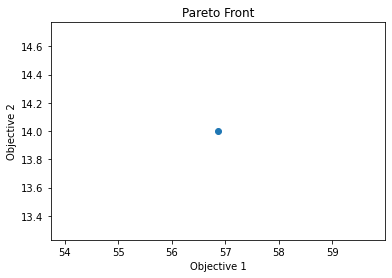

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# plot pareto front
pareto_front = np.asarray(opt.get_history().get_pareto_front())
if pareto_front.shape[-1] in (2, 3):
    if pareto_front.shape[-1] == 2:
        plt.scatter(pareto_front[:, 0], pareto_front[:, 1])
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
    elif pareto_front.shape[-1] == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(pareto_front[:, 0], pareto_front[:, 1], pareto_front[:, 2])
        ax.set_xlabel('Objective 1')
        ax.set_ylabel('Objective 2')
        ax.set_zlabel('Objective 3')
    plt.title('Pareto Front')
    plt.show()

OrderedDict([(Configuration:
  x1, Value: 1
  x10, Value: 1
  x11, Value: 1
  x12, Value: 1
  x13, Value: 1
  x14, Value: 1
  x15, Value: 1
  x2, Value: 1
  x3, Value: 1
  x4, Value: 1
  x5, Value: 1
  x6, Value: 1
  x7, Value: 1
  x8, Value: 1
  x9, Value: 1
  y1, Value: 1
  y10, Value: 1
  y11, Value: 1
  y12, Value: 1
  y13, Value: 1
  y14, Value: 1
  y15, Value: 1
  y2, Value: 1
  y3, Value: 1
  y4, Value: 1
  y5, Value: 1
  y6, Value: 1
  y7, Value: 1
  y8, Value: 1
  y9, Value: 1
, array([82.99662693, 15.        ])), (Configuration:
  x1, Value: 4
  x10, Value: 2
  x11, Value: 2
  x12, Value: 4
  x13, Value: 6
  x14, Value: 5
  x15, Value: 5
  x2, Value: 2
  x3, Value: 5
  x4, Value: 1
  x5, Value: 0
  x6, Value: 3
  x7, Value: 1
  x8, Value: 6
  x9, Value: 2
  y1, Value: 2
  y10, Value: 5
  y11, Value: 5
  y12, Value: 7
  y13, Value: 5
  y14, Value: 2
  y15, Value: 5
  y2, Value: 1
  y3, Value: 3
  y4, Value: 2
  y5, Value: 1
  y6, Value: 3
  y7, Value: 5
  y8, Value: 5
  y9, Va

TypeError: unhashable type: 'numpy.ndarray'

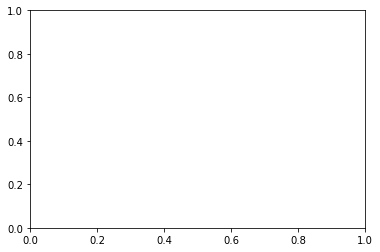

In [5]:
# plot hypervolume
data = opt.get_history().data

sensors_num = []
accuracies = []

print(data)

for _ in range(len(data)):
    d = data.popitem(last=True)
    print(d)
    accuracies.append(d[0])
    sensors_num.append(d[1])

print(accuracies)
    
plt.plot(accuracies)
    
# for item in hypervolume:
    # print(item.get_array())
    # print(item)

# log_hv_diff = 100 - np.asarray(hypervolume)
# plt.plot(log_hv_diff)
# plt.xlabel('Iteration')
# plt.ylabel('Log Hypervolume Difference')
# plt.show()

In [ ]:
opt.get_history()

In [ ]:
for index, history in enumerate(history_list):
    history.save_json(fn = '.\openbox_results\history' + str(1) + '.json')

In [ ]:
history

In [ ]:
b.hv_data

In [ ]:
def my_plot_convergence(
            results,
            xlabel="Number of iterations $n$",
            ylabel=r"Min objective value after $n$ iterations",
            ax=None, name=None, alpha=0.2, yscale=None,
            color=None, true_minimum=None,
            **kwargs):
        """Plot one or several convergence traces.
        Parameters
        ----------
        args[i] :  `OptimizeResult`, list of `OptimizeResult`, or tuple
            The result(s) for which to plot the convergence trace.
            - if `OptimizeResult`, then draw the corresponding single trace;
            - if list of `OptimizeResult`, then draw the corresponding convergence
              traces in transparency, along with the average convergence trace;
            - if tuple, then `args[i][0]` should be a string label and `args[i][1]`
              an `OptimizeResult` or a list of `OptimizeResult`.
        ax : `Axes`, optional
            The matplotlib axes on which to draw the plot, or `None` to create
            a new one.
        true_minimum : float, optional
            The true minimum value of the function, if known.
        yscale : None or string, optional
            The scale for the y-axis.
        Returns
        -------
        ax : `Axes`
            The matplotlib axes.
        """
        losses = list(results)

        n_calls = len(losses)
        iterations = range(1, n_calls + 1)
        maxs = [np.max(losses[:i]) for i in iterations]
        min_maxs = min(maxs)
        cliped_losses = np.clip(losses, min_maxs, None)
        return plot_convergence(iterations, maxs, cliped_losses, xlabel, ylabel, ax, name, alpha, yscale, color,
                                true_minimum, **kwargs)
    
def plot_convergence(
        x, y1, y2,
        xlabel="Number of iterations $n$",
        ylabel=r"Min objective value after $n$ iterations",
        ax=None, name=None, alpha=0.2, yscale=None,
        color=None, true_minimum=None,
        **kwargs):
    """Plot one or several convergence traces.
    Parameters
    ----------
    args[i] :  `OptimizeResult`, list of `OptimizeResult`, or tuple
        The result(s) for which to plot the convergence trace.
        - if `OptimizeResult`, then draw the corresponding single trace;
        - if list of `OptimizeResult`, then draw the corresponding convergence
          traces in transparency, along with the average convergence trace;
        - if tuple, then `args[i][0]` should be a string label and `args[i][1]`
          an `OptimizeResult` or a list of `OptimizeResult`.
    ax : `Axes`, optional
        The matplotlib axes on which to draw the plot, or `None` to create
        a new one.
    true_minimum : float, optional
        The true minimum value of the function, if known.
    yscale : None or string, optional
        The scale for the y-axis.
    Returns
    -------
    ax : `Axes`
        The matplotlib axes.
    """
    if ax is None:
        ax = plt.gca()

    ax.set_title("Convergence plot")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()

    if yscale is not None:
        ax.set_yscale(yscale)

    ax.plot(x, y1, c=color, label=name, **kwargs)
    ax.scatter(x, y2, c=color, alpha=alpha)

    if true_minimum is not None:
        ax.axhline(true_minimum, linestyle="--",
                   color="r", lw=1,
                   label="True minimum")

    if true_minimum is not None or name is not None:
        ax.legend(loc="upper right")
    return ax

In [ ]:
import os
from openbox.utils import history_container

history_list = []


for filename in os.listdir('.\openbox_results'):
    history = history_container.HistoryContainer(task_id = 'SPO')
    hist = history.load_history_from_json(cs = space, fn = '.\openbox_results\\' + filename)
    history_list.append(hist)

In [ ]:
for c in history_list[0].items():
    print(c[1])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for i in range(len(history_list)):
    # print(hist)
    # for c in history_list[0].items():
    # print(c[1])
    # hist.plot_convergence()
    # l = [100 - p for p in hist.perfs]
    # figure(figsize=(8, 6), dpi=80)
    # print(max(l))
    # print(min(l))
    # data = history_list[i].items()
    # print(data[1])
    # my_plot_convergence(results = data) 
    # plt.show()
    data = []
    for c in history_list[i].items():
        data.append(100 - c[1])
    
    # print(data)
    my_plot_convergence(results = data)
    plt.show()


In [ ]:
history_list

In [ ]:
    
for index, history in enumerate(history_list):
    # print(history.perfs)
    figure(figsize=(8, 6), dpi=80)
    history.plot_convergence()
    print(history.min_y)
    plt.show()

In [ ]:
rooms = {'bedroom': [(3.9, 0.0), (8.0, 4.1)],
         'livingroom': [(0.0, 1.9), (6.3, 4.3)],
         'diningroom': [(0.0, 3.0), (2.6, 8.0)],
         'kitchen': [(0.0, 3.0), (2.6, 8.0)],
         'bathroom': [(6.1, 3.3), (8.0, 6.4)],
		 'storage': [(2.8, 6.7), (8.0, 8.0)]} 

In [ ]:
A = [(([4, 8], 'storage', 'motion sensors'), ([6, 4], 'bedroom', 'motion sensors'), ([7, 5], 'bathroom', 'motion sensors'), ([3, 8], 'storage', 'motion sensors'), ([4, 8], 'storage', 'motion sensors'), ([8, 6], 'bathroom', 'motion sensors'), ([8, 0], 'bedroom', 'motion sensors'), ([8, 5], 'bathroom', 'motion sensors'), ([8, 4], 'bedroom', 'motion sensors'), ([3, 3], 'livingroom', 'motion sensors'), ([8, 4], 'bedroom', 'motion sensors'), ([3, 3], 'livingroom', 'motion sensors'), ([5, 6], 'livingroom', 'motion sensors'), ([1, 8], 'diningroom', 'motion sensors'), ([1, 8], 'diningroom', 'motion sensors'))]

In [ ]:
A

In [ ]:
for a in A:
    for aa in a:
        print(aa)
        print('----')

In [ ]:
df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))

In [ ]:
df

In [ ]:
df